# DATA CLEANING

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, UnidentifiedImageError
import zipfile

# Step 1: Path to already uploaded ZIP
zip_name = "/content/dataset2_HQ_LQ.zip"
extract_dir = "/content/dataset_raw"
os.makedirs(extract_dir, exist_ok=True)

# Step 2: Extract ZIP
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extracted HQ dataset to:", extract_dir)

# Step 3: Setup output folders
hq_dir = "/content/dataset/HQ"
lq_dir = "/content/dataset/LQ"
os.makedirs(hq_dir, exist_ok=True)
os.makedirs(lq_dir, exist_ok=True)

# Step 4: Processing function
def process_and_degrade(img_path, filename):
    try:
        img = Image.open(img_path).convert("RGB")
    except UnidentifiedImageError:
        print(f"⚠ Skipping non-image file: {filename}")
        return

    img = img.resize((256, 256), Image.LANCZOS)  # Resize

    # Save HQ version
    img.save(os.path.join(hq_dir, filename), "JPEG", quality=95)

    # Downscale & upscale for LQ
    img_small = img.resize((64, 64), Image.BICUBIC)
    img_lq = img_small.resize((256, 256), Image.BICUBIC)

    # Reduce brightness
    enhancer = ImageEnhance.Brightness(img_lq)
    img_lq = enhancer.enhance(0.7)

    # Add Gaussian noise
    img_np = np.array(img_lq, dtype=np.float32)
    noise = np.random.normal(0, 20, img_np.shape).astype(np.float32)
    img_np = np.clip(img_np + noise, 0, 255).astype(np.uint8)
    img_lq = Image.fromarray(img_np)

    # Save compressed LQ version
    img_lq.save(os.path.join(lq_dir, filename), "JPEG", quality=40)

# Step 5: Run processing
for root, _, files_list in os.walk(extract_dir):
    for file in files_list:
        # Skip hidden files like .DS_Store or files starting with ._
        if file.startswith('.') or file.lower().endswith(("jpg", "jpeg", "png")) is False:
            continue
        img_path = os.path.join(root, file)
        process_and_degrade(img_path, file)

print("✅ Dataset prepared!")
print("HQ images saved in:", hq_dir)
print("LQ images saved in:", lq_dir)

# Step 6: Zip final dataset
output_zip = "/content/dataset2_HQ_LQ.zip"
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for folder in [hq_dir, lq_dir]:
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            zipf.write(file_path, arcname=os.path.join(os.path.basename(folder), file))

print("📦 Zipped dataset ready:", output_zip)


✅ Extracted HQ dataset to: /content/dataset_raw
✅ Dataset prepared!
HQ images saved in: /content/dataset/HQ
LQ images saved in: /content/dataset/LQ
📦 Zipped dataset ready: /content/dataset2_HQ_LQ.zip


In [ ]:
import os

extract_path = '/content/dataset' # Path where the zip was extracted

hq_files = set(os.listdir(os.path.join(extract_path, 'HQ')))
lq_files = set(os.listdir(os.path.join(extract_path, 'LQ')))

# Check for duplicates within HQ and LQ (shouldn't be any if the processing was correct)
hq_duplicates = [name for name in hq_files if os.path.isfile(os.path.join(extract_path, 'HQ', name)) and os.listdir(os.path.join(extract_path, 'HQ')).count(name) > 1]
lq_duplicates = [name for name in lq_files if os.path.isfile(os.path.join(extract_path, 'LQ', name)) and os.listdir(os.path.join(extract_path, 'LQ')).count(name) > 1]


print("Duplicate filenames within HQ folder:", hq_duplicates)
print("Duplicate filenames within LQ folder:", lq_duplicates)

# Check for filenames present in both HQ and LQ (expected)
common_files = hq_files.intersection(lq_files)

print("\nNumber of files in HQ:", len(hq_files))
print("Number of files in LQ:", len(lq_files))
print("Number of common files (present in both HQ and LQ):", len(common_files))

if len(hq_files) == len(lq_files) and len(hq_files) == len(common_files):
    print("\nThe number of files in HQ and LQ folders match, and all filenames are common.")
else:
    print("\nWarning: The number of files in HQ and LQ folders do not match, or there are files not present in both.")

Duplicate filenames within HQ folder: []
Duplicate filenames within LQ folder: []

Number of files in HQ: 1203
Number of files in LQ: 1203
Number of common files (present in both HQ and LQ): 1203

The number of files in HQ and LQ folders match, and all filenames are common.


# MODEL TRANING

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your zip file here


Saving dataset2_HQ_LQ.zip to dataset2_HQ_LQ (1).zip


In [ ]:
import zipfile
import os

zip_path = "/content/dataset2_HQ_LQ.zip"  # uploaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Now the dataset is available at /content/dataset2_HQ_LQ/HQ and /content/dataset2_HQ_LQ/LQ


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import cv2

# =============================
# 1. Dataset Paths
# =============================
hq_dir = "/content/HQ"
lq_dir = "/content/LQ"
IMG_SIZE = (256, 256)

def load_images_from_folder(folder, size=IMG_SIZE):
    images = []
    for file in os.listdir(folder):
        if file.lower().endswith(("jpg", "jpeg", "png")):
            img_path = os.path.join(folder, file)
            img = load_img(img_path, target_size=size)
            img = img_to_array(img) / 255.0
            images.append(img)
    return np.array(images)

print("📂 Loading dataset ...")
X = load_images_from_folder(lq_dir)  # LQ
Y = load_images_from_folder(hq_dir)  # HQ
print(f"✅ Loaded {X.shape[0]} image pairs! Shape: {X.shape}")

📂 Loading dataset ...
✅ Loaded 1203 image pairs! Shape: (1203, 256, 256, 3)


In [ ]:
# =============================
# 2. Train-test split
# =============================
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# =============================
# 3. Build Autoencoder Model
# =============================
def build_autoencoder(input_shape=(256, 256, 3)):
    inp = Input(shape=input_shape)

    # Encoder
    e1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inp)
    e1 = MaxPooling2D((2, 2), padding="same")(e1)

    e2 = Conv2D(128, (3, 3), activation="relu", padding="same")(e1)
    e2 = MaxPooling2D((2, 2), padding="same")(e2)

    e3 = Conv2D(256, (3, 3), activation="relu", padding="same")(e2)

    # Decoder
    d1 = UpSampling2D((2, 2))(e3)
    d1 = Conv2D(128, (3, 3), activation="relu", padding="same")(d1)

    d2 = UpSampling2D((2, 2))(d1)
    d2 = Conv2D(64, (3, 3), activation="relu", padding="same")(d2)

    out = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(d2)

    model = Model(inp, out)
    return model

model = build_autoencoder()

model.compile(optimizer=Adam(1e-4), loss="mse", metrics=["mae"])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,379 (2.83 MB)

 Trainable params: 741,379 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# =============================
# 4. Train Model
# =============================
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=8
)

# Save the trained model
model.save("enhancement_model.h5")
print("✅ Model saved as enhancement_model.h5")

Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 274ms/step - loss: 0.0760 - mae: 0.2281 - val_loss: 0.0123 - val_mae: 0.0776
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - loss: 0.0103 - mae: 0.0707 - val_loss: 0.0082 - val_mae: 0.0602
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - loss: 0.0076 - mae: 0.0580 - val_loss: 0.0070 - val_mae: 0.0539
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - loss: 0.0068 - mae: 0.0538 - val_loss: 0.0070 - val_mae: 0.0533
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - loss: 0.0060 - mae: 0.0485 - val_loss: 0.0062 - val_mae: 0.0515
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - loss: 0.0055 - mae: 0.0453 - val_loss: 0.0058 - val_mae: 0.0467
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - loss: 0.0053 - mae: 0.0445 - val_loss: 0.0053 - val_mae: 0.0437
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - loss: 0.0050 - mae: 0.0421 - val_loss: 0.0052 - val_mae: 0.0429
Epoch 9/20
121/121 ━━━━━━━━━━━━━

✅ Model saved as enhancement_model.h5


# Opencv

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import load_model
import sys

# ========================================================
# 1️⃣ Configuration
# ========================================================
IMG_SIZE = (256, 256)
MODEL_PATH = "/content/enhancement_model.h5"  # your trained model path

# Load trained model
try:
    model = load_model(MODEL_PATH)
    print(f"✅ Loaded trained model from {MODEL_PATH}")
except Exception as e:
    print("❌ Error loading model:", e)
    sys.exit()

# ========================================================
# 2️⃣ Webcam Capture Function (Local + Colab)
# ========================================================
def capture_image():
    """
    Captures an image from webcam.
    Works in both local (cv2.VideoCapture) and Google Colab (browser camera).
    """
    try:
        # --- For local system (OpenCV) ---
        cap = cv2.VideoCapture(0)
        if cap.isOpened():
            print("📸 Press SPACE to capture, ESC to exit...")
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("❌ Failed to grab frame!")
                    break
                cv2.imshow("Camera - Press SPACE to Capture", frame)
                key = cv2.waitKey(1)
                if key % 256 == 27:
                    print("🚪 Exiting without capture.")
                    break
                elif key % 256 == 32:
                    captured = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    cap.release()
                    cv2.destroyAllWindows()
                    print("✅ Image captured successfully!")
                    return captured
            cap.release()
            cv2.destroyAllWindows()

        # --- For Colab (browser-based camera) ---
        else:
            from IPython.display import Javascript
            from google.colab.output import eval_js
            from base64 import b64decode
            from io import BytesIO

            print("🌐 Using browser-based camera (Colab)...")

            js = Javascript('''
            async function takePhoto() {
              const div = document.createElement('div');
              const capture = document.createElement('button');
              capture.textContent = '📸 Capture';
              div.appendChild(capture);
              document.body.appendChild(div);
              const video = document.createElement('video');
              video.style.display = 'block';
              document.body.appendChild(video);
              const stream = await navigator.mediaDevices.getUserMedia({video: true});
              video.srcObject = stream;
              await video.play();
              await new Promise((resolve) => capture.onclick = resolve);
              const canvas = document.createElement('canvas');
              canvas.width = video.videoWidth;
              canvas.height = video.videoHeight;
              canvas.getContext('2d').drawImage(video, 0, 0);
              stream.getTracks().forEach(t => t.stop());
              const data = canvas.toDataURL('image/png');
              return data;
            }
            ''')
            display(js)
            data = eval_js('takePhoto()')
            binary = b64decode(data.split(',')[1])
            img = Image.open(BytesIO(binary)).convert('RGB')
            print("✅ Image captured via browser!")
            return np.array(img)

    except Exception as e:
        print("⚠️ Camera access error:", e)
        return None

# ========================================================
# 3️⃣ Preprocess → Predict → Display → Save
# ========================================================
def enhance_captured_image(captured_image):
    """Enhance captured image using trained CNN model."""
    if captured_image is None:
        print("⚠️ No image captured.")
        return

    # Preprocess
    img_pil = Image.fromarray(captured_image)
    img_resized = img_pil.resize(IMG_SIZE)
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    print("✨ Enhancing image using trained model...")
    enhanced_array = model.predict(img_array)[0]
    enhanced_pil = array_to_img(enhanced_array * 255.0)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title("Captured Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_pil)
    plt.title("Enhanced Image (Model Output)")
    plt.axis("off")
    plt.show()

    # Save output
    save_path = "enhanced_captured_image.jpg"
    enhanced_pil.save(save_path)
    print(f"💾 Enhanced image saved as '{save_path}'")

# ========================================================
# 4️⃣ Run the Complete Pipeline
# ========================================================
captured_image = capture_image()
enhance_captured_image(captured_image)





ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



❌ Error loading model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Traceback (most recent call last):
  File "/tmp/ipython-input-3447323590.py", line 18, in <cell line: 0>
    model = load_model(MODEL_PATH)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py", line 196, in load_model
    return legacy_h5_format.load_model_from_hdf5(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/saving/legacy_h5_format.py", line 155, in load_model_from_hdf5
    **saving_utils.compile_args_from_training_config(
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/saving/saving_utils.py", line 146, in compile_args_from

TypeError: object of type 'NoneType' has no len()

✅ Loaded and compiled model successfully from /content/enhancement_model.h5
🌐 Using browser-based camera (Colab)...


<IPython.core.display.Javascript object>

✅ Image captured via browser!
✨ Enhancing image using trained model...


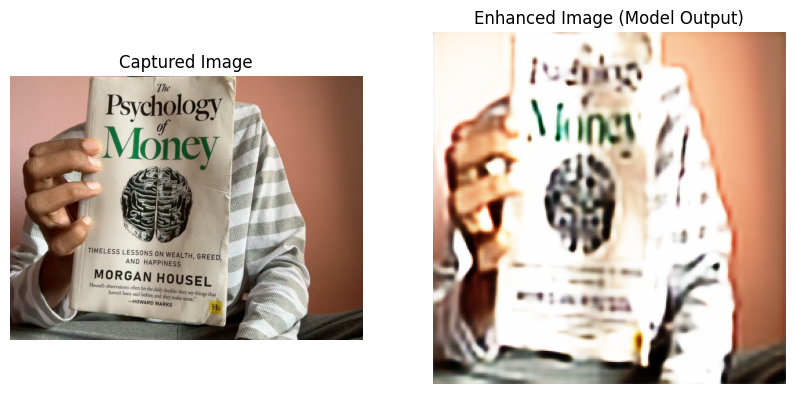

💾 Enhanced image saved as 'enhanced_captured_image.jpg'


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import load_model
import tensorflow as tf
import sys

# ========================================================
# 1️⃣ Configuration
# ========================================================
IMG_SIZE = (256, 256)
MODEL_PATH = "/content/enhancement_model.h5"  # your trained model path

# ========================================================
# 2️⃣ Safe Model Loader (Fixes 'mse' issue)
# ========================================================
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

# Register legacy losses/metrics for backward compatibility
tf.keras.utils.get_custom_objects().update({
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError(),
})

try:
    model = load_model(MODEL_PATH, compile=False)
    model.compile(optimizer="adam", loss=MeanSquaredError())
    print(f"✅ Loaded and compiled model successfully from {MODEL_PATH}")
except Exception as e:
    print("❌ Error loading model:", e)
    sys.exit()

# ========================================================
# 3️⃣ Webcam Capture Function (Local + Colab)
# ========================================================
def capture_image():
    """Captures an image from webcam. Works in local and Colab."""
    try:
        cap = cv2.VideoCapture(0)
        if cap.isOpened():
            print("📸 Press SPACE to capture, ESC to exit...")
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("❌ Failed to grab frame!")
                    break
                cv2.imshow("Camera - Press SPACE to Capture", frame)
                key = cv2.waitKey(1)
                if key % 256 == 27:
                    print("🚪 Exiting without capture.")
                    break
                elif key % 256 == 32:
                    captured = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    cap.release()
                    cv2.destroyAllWindows()
                    print("✅ Image captured successfully!")
                    return captured
            cap.release()
            cv2.destroyAllWindows()

        # --- For Colab (browser-based camera) ---
        else:
            from IPython.display import Javascript, display
            from google.colab.output import eval_js
            from base64 import b64decode
            from io import BytesIO

            print("🌐 Using browser-based camera (Colab)...")

            js = Javascript('''
            async function takePhoto() {
              const div = document.createElement('div');
              const capture = document.createElement('button');
              capture.textContent = '📸 Capture';
              div.appendChild(capture);
              document.body.appendChild(div);
              const video = document.createElement('video');
              video.style.display = 'block';
              document.body.appendChild(video);
              const stream = await navigator.mediaDevices.getUserMedia({video: true});
              video.srcObject = stream;
              await video.play();
              await new Promise((resolve) => capture.onclick = resolve);
              const canvas = document.createElement('canvas');
              canvas.width = video.videoWidth;
              canvas.height = video.videoHeight;
              canvas.getContext('2d').drawImage(video, 0, 0);
              stream.getTracks().forEach(t => t.stop());
              const data = canvas.toDataURL('image/png');
              return data;
            }
            ''')
            display(js)
            data = eval_js('takePhoto()')
            binary = b64decode(data.split(',')[1])
            img = Image.open(BytesIO(binary)).convert('RGB')
            print("✅ Image captured via browser!")
            return np.array(img)

    except Exception as e:
        print("⚠️ Camera access error:", e)
        return None

# ========================================================
# 4️⃣ Enhance Captured Image
# ========================================================
def enhance_captured_image(captured_image):
    """Enhance captured image using trained CNN model."""
    if captured_image is None:
        print("⚠️ No image captured.")
        return

    # Preprocess
    img_pil = Image.fromarray(captured_image)
    img_resized = img_pil.resize(IMG_SIZE)
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    print("✨ Enhancing image using trained model...")
    enhanced_array = model.predict(img_array, verbose=0)[0]
    enhanced_pil = array_to_img(np.clip(enhanced_array, 0, 1))

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title("Captured Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_pil)
    plt.title("Enhanced Image (Model Output)")
    plt.axis("off")
    plt.show()

    # Save output
    save_path = "enhanced_captured_image.jpg"
    enhanced_pil.save(save_path)
    print(f"💾 Enhanced image saved as '{save_path}'")

# ========================================================
# 5️⃣ Run the Complete Pipeline
# ========================================================
captured_image = capture_image()
enhance_captured_image(captured_image)


In [ ]:
!pip install torch torchvision diffusers transformers accelerate safetensors
!pip install opencv-python pillow basicsr realesrgan huggingface_hub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 16.3 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=be028d74bf87aac3060c5f29519a37d22c12f92b1275a742a3689fe51d5330a5
  Stored in directory: /root/.cache/pip/wheels/9a/e3/e4/58f29bfabb622dd40b6d9839318ce5bf092062b81ca3aa19ea
  Created wheel for f

In [ ]:
# ======================================================
# 🚀 FULL WORKING Real-ESRGAN COLAB SETUP
# ======================================================

# 1️⃣ Install compatible versions
!pip install -q torch==2.2.2 torchvision==0.17.2
!pip install -q basicsr==1.4.2 realesrgan==0.3.0 huggingface_hub opencv-python pillow

# 2️⃣ Imports
from huggingface_hub import hf_hub_download
import cv2
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from google.colab import files
from IPython.display import Image, display

# 3️⃣ Download pretrained weights
model_path = hf_hub_download(repo_id="ai-forever/Real-ESRGAN", filename="RealESRGAN_x4.pth")

# 4️⃣ Initialize the model
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23,
                num_grow_ch=32, scale=4)
upscaler = RealESRGANer(scale=4, model_path=model_path, model=model,
                        tile=0, half=False)

# 5️⃣ Upload an image
uploaded = files.upload()
input_path = list(uploaded.keys())[0]
print("✅ Uploaded:", input_path)

# 6️⃣ Enhance
img = cv2.imread(input_path, cv2.IMREAD_COLOR)
output, _ = upscaler.enhance(img, outscale=4)

# 7️⃣ Save & show
cv2.imwrite("enhanced_product.jpg", output)
print("✅ Enhanced image saved as enhanced_product.jpg")
display(Image("enhanced_product.jpg"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [ ]:
# ======================================================
# 🚀 FULL WORKING REAL-ESRGAN COLAB SETUP
# ======================================================

# 1️⃣ Clean up any conflicting versions
!pip uninstall -y torch torchvision torchaudio basicsr realesrgan facexlib gfpgan

# 2️⃣ Install compatible versions (this fixes the functional_tensor error)
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install realesrgan==0.3.0 basicsr==1.4.2 facexlib==0.2.5 gfpgan==1.3.8 opencv-python pillow huggingface_hub

# 3️⃣ Imports
import cv2
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from huggingface_hub import hf_hub_download
from google.colab import files
from IPython.display import Image, display
import numpy as np

# 4️⃣ Download pretrained weights automatically
model_path = hf_hub_download(repo_id="ai-forever/Real-ESRGAN", filename="RealESRGAN_x4.pth")

# 5️⃣ Initialize the model
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64,
                num_block=23, num_grow_ch=32, scale=4)
upsampler = RealESRGANer(
    scale=4,
    model_path=model_path,
    model=model,
    tile=400,
    tile_pad=10,
    pre_pad=0,
    half=True
)

# 6️⃣ Upload your image
uploaded = files.upload()
input_path = list(uploaded.keys())[0]
print("✅ Uploaded:", input_path)

# 7️⃣ Read image
img = cv2.imread(input_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 8️⃣ Run Real-ESRGAN enhancement
output, _ = upsampler.enhance(img, outscale=4)

# 9️⃣ Save & display
output_bgr = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
cv2.imwrite("enhanced_product.png", output_bgr)
display(Image("enhanced_product.png"))
print("✅ Enhanced image saved as enhanced_product.png")


Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Found existing installation: torchvision 0.23.0
Uninstalling torchvision-0.23.0:
  Successfully uninstalled torchvision-0.23.0
Found existing installation: basicsr 1.4.2
Uninstalling basicsr-1.4.2:
  Successfully uninstalled basicsr-1.4.2
Found existing installation: realesrgan 0.3.0
Uninstalling realesrgan-0.3.0:
  Successfully uninstalled realesrgan-0.3.0
Found existing installation: facexlib 0.2.5
Uninstalling facexlib-0.2.5:
  Successfully uninstalled facexlib-0.2.5
Found existing installation: gfpgan 1.3.8
Uninstalling gfpgan-1.3.8:
  Successfully uninstalled gfpgan-1.3.8
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
ERROR: Could not find a version that satisfies the requirement torch==1.13.1+cu116 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution foun

ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [ ]:
# 1️⃣ Install necessary libraries
!pip install huggingface_hub pillow

# 2️⃣ Imports
from huggingface_hub import InferenceClient
from PIL import Image
from google.colab import files
from IPython.display import display

# 3️⃣ Initialize the InferenceClient
client = InferenceClient()

# 4️⃣ Upload your image
uploaded = files.upload()
input_path = list(uploaded.keys())[0]
img = Image.open(input_path).convert("RGB")
display(img)

# 5️⃣ Perform inference using the Real-ESRGAN model
repo_id = "ai-forever/Real-ESRGAN"
enhanced_img = client(repo_id=repo_id, inputs=img)

# 6️⃣ Display and save the enhanced image
enhanced_img.save("enhanced_product.png")
display(enhanced_img)
print("✅ Enhanced image saved as enhanced_product.png")


MessageError: RangeError: Maximum call stack size exceeded.

In [ ]:
# 1️⃣ Install necessary libraries
!pip install huggingface_hub pillow opencv-python

# 2️⃣ Imports
from huggingface_hub import InferenceClient
from PIL import Image
import cv2
from IPython.display import display

# 3️⃣ Initialize the Hugging Face Inference Client
client = InferenceClient()

# 4️⃣ Capture photo from webcam using OpenCV
cap = cv2.VideoCapture(0)  # 0 = default webcam

if not cap.isOpened():
    raise RuntimeError("Could not open webcam. Check permissions.")

print("📸 Press 'SPACE' to capture photo, 'ESC' to quit.")
while True:
    ret, frame = cap.read()
    if not ret:
        continue
    cv2.imshow("Webcam - Press SPACE to capture", frame)

    key = cv2.waitKey(1)
    if key % 256 == 27:  # ESC
        print("Escape pressed, closing webcam.")
        cap.release()
        cv2.destroyAllWindows()
        raise SystemExit
    elif key % 256 == 32:  # SPACE
        img_cv2 = frame
        break

cap.release()
cv2.destroyAllWindows()

# Convert OpenCV BGR frame to PIL Image (RGB)
img = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img)
display(img_pil)

# 5️⃣ Perform inference using Real-ESRGAN via Hugging Face API
repo_id = "ai-forever/Real-ESRGAN"
enhanced_img = client(repo_id=repo_id, inputs=img_pil)

# 6️⃣ Display and save the enhanced image
enhanced_img.save("enhanced_product.png")
display(enhanced_img)
print("✅ Enhanced image saved as enhanced_product.png")


RuntimeError: Could not open webcam. Check permissions.

In [ ]:
!pip install --quiet opencv-python pillow

import cv2, os, requests, base64, numpy as np
from PIL import Image
from io import BytesIO
from datetime import datetime
from IPython.display import display, Javascript
from google.colab import output
import time

# -----------------------------
# Configuration
# -----------------------------
API_URL = "https://api-inference.huggingface.co/models/nateraw/real-esrgan"
HF_API_TOKEN = os.getenv("HF_API_TOKEN", None)

HEADERS = {"Accept": "image/png"}
if HF_API_TOKEN:
    HEADERS["Authorization"] = f"Bearer {HF_API_TOKEN}"

# -----------------------------
# Helper: save webcam photo
# -----------------------------
def save_photo_from_data_url(data_url, filename):
    header, encoded = data_url.split(",", 1)
    data = BytesIO(base64.b64decode(encoded))
    img = Image.open(data)
    img.save(filename)
    print(f"✅ Captured: {filename}")

output.register_callback('notebook.save_photo', save_photo_from_data_url)

# -----------------------------
# Helper: capture webcam in Colab
# -----------------------------
def capture_image_colab(filename="captured.jpg"):
    js = """
    async function takePhoto() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      const context = canvas.getContext('2d');

      await new Promise((resolve) => {
        const button = document.createElement('button');
        button.textContent = 'Capture';
        div.appendChild(button);
        button.onclick = () => resolve();
      });

      context.drawImage(video, 0, 0, canvas.width, canvas.height);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      const dataUrl = canvas.toDataURL('image/jpeg');
      google.colab.kernel.invokeFunction('notebook.save_photo', [dataUrl], {});
    }
    takePhoto();
    """
    display(Javascript(js))
    print("📸 Capture window opened. Click 'Capture' to take a photo.")
    # Wait a little for user to capture
    for i in range(30):
        if os.path.exists(filename):
            break
        time.sleep(0.5)
    if not os.path.exists(filename):
        raise RuntimeError("No photo captured in time.")
    return filename

# -----------------------------
# Helper: enhance image via HF
# -----------------------------
def enhance_image_bytes(image_bytes: bytes) -> bytes:
    resp = requests.post(API_URL, headers=HEADERS, data=image_bytes, timeout=120)
    if resp.status_code == 200:
        return resp.content
    else:
        raise RuntimeError(f"HTTP {resp.status_code} - {resp.text}")

def run_enhancement(input_path: str) -> str:
    with open(input_path, "rb") as f:
        img_bytes = f.read()
    out_bytes = enhance_image_bytes(img_bytes)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = f"enhanced_{timestamp}.png"
    with open(out_path, "wb") as f:
        f.write(out_bytes)
    print(f"✅ Enhanced image saved as: {out_path}")
    return out_path

# -----------------------------
# Helper: show side-by-side in Colab
# -----------------------------
def show_side_by_side(before_path, after_path):
    before = np.array(Image.open(before_path))
    after = np.array(Image.open(after_path))
    h_target = 512
    def resize_keep_aspect(img, h_target):
        h, w = img.shape[:2]
        scale = h_target / h
        return cv2.resize(img, (int(w*scale), h_target))
    before_r, after_r = resize_keep_aspect(before, h_target), resize_keep_aspect(after, h_target)
    combined = np.hstack((before_r, after_r))
    display(Image.fromarray(combined))

# -----------------------------
# Run full workflow
# -----------------------------
try:
    captured = capture_image_colab("captured.jpg")
    enhanced = run_enhancement(captured)
    show_side_by_side(captured, enhanced)
except Exception as e:
    print("❌ Error:", e)


<IPython.core.display.Javascript object>

📸 Capture window opened. Click 'Capture' to take a photo.
❌ Error: No photo captured in time.


In [ ]:
!pip install --quiet pillow opencv-python requests

import os, requests, base64, numpy as np, time
from PIL import Image
from io import BytesIO
from datetime import datetime
from IPython.display import display, Javascript
from google.colab import output
import cv2

# -----------------------------
# Hugging Face configuration
# -----------------------------
API_URL = "https://api-inference.huggingface.co/models/nateraw/real-esrgan"
HF_API_TOKEN = os.getenv("HF_API_TOKEN", None)
HEADERS = {"Accept": "image/png"}
if HF_API_TOKEN:
    HEADERS["Authorization"] = f"Bearer {HF_API_TOKEN}"

# -----------------------------
# Save webcam photo
# -----------------------------
def save_photo_from_data_url(data_url, filename):
    header, encoded = data_url.split(",", 1)
    data = BytesIO(base64.b64decode(encoded))
    img = Image.open(data)
    img.save(filename)
    print(f"✅ Captured: {filename}")

output.register_callback('notebook.save_photo', save_photo_from_data_url)

# -----------------------------
# Capture image from webcam
# -----------------------------
def capture_image_colab(filename="captured.jpg"):
    js = """
    async function takePhoto() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      const context = canvas.getContext('2d');
      await new Promise((resolve) => {
        const button = document.createElement('button');
        button.textContent = 'Capture';
        div.appendChild(button);
        button.onclick = () => resolve();
      });
      context.drawImage(video, 0, 0, canvas.width, canvas.height);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      const dataUrl = canvas.toDataURL('image/jpeg');
      google.colab.kernel.invokeFunction('notebook.save_photo', [dataUrl], {});
    }
    takePhoto();
    """
    display(Javascript(js))
    print("📸 Capture window opened. Click 'Capture'.")
    for i in range(30):
        if os.path.exists(filename):
            break
        time.sleep(0.5)
    if not os.path.exists(filename):
        raise RuntimeError("No photo captured.")
    return filename

# -----------------------------
# Enhance image via Hugging Face
# -----------------------------
def enhance_image_bytes(image_bytes: bytes) -> bytes:
    resp = requests.post(API_URL, headers=HEADERS, data=image_bytes, timeout=120)
    if resp.status_code == 200:
        return resp.content
    else:
        raise RuntimeError(f"HTTP {resp.status_code} - {resp.text}")

def run_enhancement(input_path: str) -> str:
    with open(input_path, "rb") as f:
        img_bytes = f.read()
    out_bytes = enhance_image_bytes(img_bytes)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = f"enhanced_{timestamp}.png"
    with open(out_path, "wb") as f:
        f.write(out_bytes)
    print(f"✅ Enhanced image saved as: {out_path}")
    return out_path

# -----------------------------
# Display side-by-side
# -----------------------------
def show_side_by_side(before_path, after_path):
    before = np.array(Image.open(before_path))
    after = np.array(Image.open(after_path))
    h_target = 512
    def resize_keep_aspect(img, h_target):
        h, w = img.shape[:2]
        scale = h_target / h
        return cv2.resize(img, (int(w*scale), h_target))
    before_r, after_r = resize_keep_aspect(before, h_target), resize_keep_aspect(after, h_target)
    combined = np.hstack((before_r, after_r))
    display(Image.fromarray(combined))

# -----------------------------
# Full workflow
# -----------------------------
try:
    captured = capture_image_colab("captured.jpg")
    enhanced = run_enhancement(captured)
    show_side_by_side(captured, enhanced)
except Exception as e:
    print("❌ Error:", e)


<IPython.core.display.Javascript object>

📸 Capture window opened. Click 'Capture'.
❌ Error: No photo captured.


In [ ]:
!pip install --quiet opencv-python pillow requests


In [ ]:
#!/usr/bin/env python3
"""
Webcam capture + Real-ESRGAN enhancement locally
"""

import cv2
import os
import requests
from PIL import Image
from datetime import datetime
import numpy as np

# -----------------------------
# Configuration
# -----------------------------
API_URL = "https://api-inference.huggingface.co/models/nateraw/real-esrgan"  # public access
HF_API_TOKEN = os.getenv("HF_API_TOKEN", None)

HEADERS = {"Accept": "image/png"}
if HF_API_TOKEN:
    HEADERS["Authorization"] = f"Bearer {HF_API_TOKEN}"

# -----------------------------
# Send image bytes to HF and get enhanced result
# -----------------------------
def enhance_image_bytes(image_bytes: bytes) -> bytes:
    resp = requests.post(API_URL, headers=HEADERS, data=image_bytes, timeout=120)
    if resp.status_code == 200:
        return resp.content
    else:
        raise RuntimeError(f"HTTP {resp.status_code} - {resp.text}")

# -----------------------------
# Capture from webcam
# -----------------------------
def capture_from_webcam() -> str:
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError("Could not open webcam. Check permissions.")

    print("📸 Webcam started. Press SPACE to capture, ESC to exit.")
    filename = None
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        cv2.imshow("Webcam - Press SPACE to capture", frame)
        key = cv2.waitKey(1) & 0xFF

        if key == 27:  # ESC
            print("Exiting without capture.")
            break
        elif key == 32:  # SPACE
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"captured_{timestamp}.jpg"
            cv2.imwrite(filename, frame)
            print(f"✅ Captured: {filename}")
            break

    cap.release()
    cv2.destroyAllWindows()
    if filename is None:
        raise SystemExit("No image captured.")
    return filename

# -----------------------------
# Enhance image via HF
# -----------------------------
def run_enhancement(input_path: str) -> str:
    print("🚀 Sending image to Real-ESRGAN...")
    with open(input_path, "rb") as f:
        img_bytes = f.read()
    out_bytes = enhance_image_bytes(img_bytes)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = f"enhanced_{timestamp}.png"
    with open(out_path, "wb") as f:
        f.write(out_bytes)
    print(f"✅ Enhanced image saved as: {out_path}")
    return out_path

# -----------------------------
# Show side-by-side
# -----------------------------
def show_side_by_side(before_path: str, after_path: str):
    before = cv2.imread(before_path)
    after = cv2.imread(after_path)
    h_target = 720

    def resize_keep_aspect(img, h_target):
        h, w = img.shape[:2]
        scale = h_target / h
        return cv2.resize(img, (int(w*scale), h_target))

    before_r = resize_keep_aspect(before, h_target)
    after_r = resize_keep_aspect(after, h_target)
    combined = np.hstack((before_r, after_r))
    cv2.imshow("Before | After", combined)
    print("Preview window opened. Press any key to close.")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# -----------------------------
# Main
# -----------------------------
def main():
    try:
        captured = capture_from_webcam()
        enhanced = run_enhancement(captured)
        show_side_by_side(captured, enhanced)
    except Exception as e:
        print("❌ Error:", e)

if __name__ == "__main__":
    main()


❌ Error: Could not open webcam. Check permissions.


In [ ]:
# Install dependencies (run once)
!pip install --quiet opencv-python pillow requests

# -----------------------------
# Imports
# -----------------------------
import cv2
import os
import requests
from PIL import Image
from datetime import datetime
import numpy as np
from google.colab import files

# -----------------------------
# Configuration
# -----------------------------
API_URL = "https://api-inference.huggingface.co/models/nateraw/real-esrgan"
HF_API_TOKEN = os.getenv("HF_API_TOKEN", None)  # optional

HEADERS = {"Accept": "image/png"}
if HF_API_TOKEN:
    HEADERS["Authorization"] = f"Bearer {HF_API_TOKEN}"

# -----------------------------
# Send image bytes to HF
# -----------------------------
def enhance_image_bytes(image_bytes: bytes) -> bytes:
    resp = requests.post(API_URL, headers=HEADERS, data=image_bytes, timeout=120)
    if resp.status_code == 200:
        return resp.content
    else:
        raise RuntimeError(f"HTTP {resp.status_code} - {resp.text}")

# -----------------------------
# Upload file from Colab
# -----------------------------
def upload_file_colab() -> str:
    print("📤 Upload an image from your computer")
    uploaded = files.upload()
    input_path = list(uploaded.keys())[0]
    print(f"✅ Uploaded: {input_path}")
    return input_path

# -----------------------------
# Enhance image via HF
# -----------------------------
def run_enhancement(input_path: str) -> str:
    print("🚀 Sending image to Real-ESRGAN...")
    with open(input_path, "rb") as f:
        img_bytes = f.read()
    out_bytes = enhance_image_bytes(img_bytes)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = f"enhanced_{timestamp}.png"
    with open(out_path, "wb") as f:
        f.write(out_bytes)
    print(f"✅ Enhanced image saved as: {out_path}")
    return out_path

# -----------------------------
# Show side-by-side using OpenCV
# -----------------------------
def show_side_by_side(before_path: str, after_path: str):
    before = cv2.imread(before_path)
    after = cv2.imread(after_path)
    h_target = 512  # resize height for Colab

    def resize_keep_aspect(img, h_target):
        h, w = img.shape[:2]
        scale = h_target / h
        return cv2.resize(img, (int(w*scale), h_target))

    before_r = resize_keep_aspect(before, h_target)
    after_r = resize_keep_aspect(after, h_target)
    combined = np.hstack((before_r, after_r))
    # Convert BGR to RGB for displaying in Colab
    combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
    # Use PIL to display in Colab
    display(Image.fromarray(combined_rgb))

# -----------------------------
# Main workflow
# -----------------------------
def main():
    try:
        input_path = upload_file_colab()
        enhanced_path = run_enhancement(input_path)
        show_side_by_side(input_path, enhanced_path)
    except Exception as e:
        print("❌ Error:", e)

if __name__ == "__main__":
    main()


📤 Upload an image from your computer


❌ Error: RangeError: Maximum call stack size exceeded.


In [ ]:
# Install dependencies (run once)
!pip install --quiet opencv-python pillow requests

# -----------------------------
# Imports
# -----------------------------
import cv2
import os
import requests
from PIL import Image
from datetime import datetime
import numpy as np
from google.colab import files
from IPython.display import display

# -----------------------------
# Configuration
# -----------------------------
API_URL = "https://api-inference.huggingface.co/models/nateraw/real-esrgan"
HF_API_TOKEN = os.getenv("HF_API_TOKEN", None)  # optional

HEADERS = {"Accept": "image/png"}
if HF_API_TOKEN:
    HEADERS["Authorization"] = f"Bearer {HF_API_TOKEN}"

# -----------------------------
# Send image bytes to HF
# -----------------------------
def enhance_image_bytes(image_bytes: bytes) -> bytes:
    resp = requests.post(API_URL, headers=HEADERS, data=image_bytes, timeout=120)
    if resp.status_code == 200:
        return resp.content
    else:
        raise RuntimeError(f"HTTP {resp.status_code} - {resp.text}")

# -----------------------------
# Upload file from Colab
# -----------------------------
def upload_file_colab() -> str:
    print("📤 Upload an image from your computer")
    uploaded = files.upload()
    input_path = list(uploaded.keys())[0]
    print(f"✅ Uploaded: {input_path}")
    return input_path

# -----------------------------
# Enhance image via HF
# -----------------------------
def run_enhancement(input_path: str) -> str:
    print("🚀 Sending image to Real-ESRGAN...")
    with open(input_path, "rb") as f:
        img_bytes = f.read()
    out_bytes = enhance_image_bytes(img_bytes)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = f"enhanced_{timestamp}.png"
    with open(out_path, "wb") as f:
        f.write(out_bytes)
    print(f"✅ Enhanced image saved as: {out_path}")
    return out_path

# -----------------------------
# Show side-by-side using OpenCV
# -----------------------------
def show_side_by_side(before_path: str, after_path: str):
    before = cv2.imread(before_path)
    after = cv2.imread(after_path)
    h_target = 512  # resize height for Colab

    def resize_keep_aspect(img, h_target):
        h, w = img.shape[:2]
        scale = h_target / h
        return cv2.resize(img, (int(w*scale), h_target))

    before_r = resize_keep_aspect(before, h_target)
    after_r = resize_keep_aspect(after, h_target)
    combined = np.hstack((before_r, after_r))
    # Convert BGR to RGB for Colab display
    combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(combined_rgb))

# -----------------------------
# Main workflow
# -----------------------------
def main():
    try:
        input_path = upload_file_colab()
        enhanced_path = run_enhancement(input_path)
        show_side_by_side(input_path, enhanced_path)
    except Exception as e:
        print("❌ Error:", e)

if __name__ == "__main__":
    main()


📤 Upload an image from your computer


❌ Error: RangeError: Maximum call stack size exceeded.


#ADDING FILTERS

Preset Filters:

 1.Classic White Studio
2.Glass Table with Reflections
3.Dark Mode Luxury Look
4.Outdoor Natural Light

In [ ]:
from PIL import ImageEnhance, ImageOps
import numpy as np
import cv2

def apply_filter(image, filter_choice):
    img_np = np.array(image)

    if filter_choice == "Classic White Studio":
        img = Image.fromarray(img_np) # Convert back to PIL for ImageOps
        img = ImageOps.autocontrast(img)
        img = ImageEnhance.Brightness(img).enhance(1.2)
        img = ImageEnhance.Color(img).enhance(1.1)
        img_np = np.array(img) # Convert back to NumPy for later steps
        return Image.fromarray(img_np)

    elif filter_choice == "Glass Table with Reflections":
        img = Image.fromarray(img_np) # Convert back to PIL for operations
        reflection = img.transpose(Image.FLIP_TOP_BOTTOM)
        reflection = ImageEnhance.Brightness(reflection).enhance(0.3)
        new_img = Image.new("RGB", (img.width, img.height*2))
        new_img.paste(img, (0,0))
        new_img.paste(reflection, (0,img.height))
        img_np = np.array(new_img) # Convert back to NumPy
        return Image.fromarray(img_np)

    elif filter_choice == "Dark Mode Luxury Look":
        img = Image.fromarray(img_np) # Convert back to PIL for enhancements
        img = ImageEnhance.Brightness(img).enhance(0.6)
        img = ImageEnhance.Contrast(img).enhance(1.5)
        img = ImageEnhance.Color(img).enhance(0.8)
        img_np = np.array(img) # Convert back to NumPy
        return Image.fromarray(img_np)

    elif filter_choice == "Outdoor Natural Light":
        img = Image.fromarray(img_np) # Convert back to PIL for enhancements
        img = ImageEnhance.Brightness(img).enhance(1.3)
        img = ImageEnhance.Color(img).enhance(1.2)
        img_np = np.array(img) # Convert back to NumPy
        return Image.fromarray(img_np)

    # If no filter matches, return the original image
    return image

#TESTING

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# --- Case 1: Model enhancement results ---
def show_model_results(lq_img, hq_img, predicted_img):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(lq_img)
    axs[0].set_title("Low Quality (LQ)")
    axs[0].axis("off")

    axs[1].imshow(hq_img)
    axs[1].set_title("Ground Truth HQ")
    axs[1].axis("off")

    axs[2].imshow(predicted_img)
    axs[2].set_title("Predicted HQ")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()



In [ ]:

# --- Case 2: Filter results ---
def show_filter_results(lq_img, hq_img, filter_img, filter_name):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(lq_img)
    axs[0].set_title("Low Quality (LQ)")
    axs[0].axis("off")

    axs[1].imshow(hq_img)
    axs[1].set_title("Ground Truth HQ")
    axs[1].axis("off")

    axs[2].imshow(filter_img)
    axs[2].set_title(f"Filter: {filter_name}")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


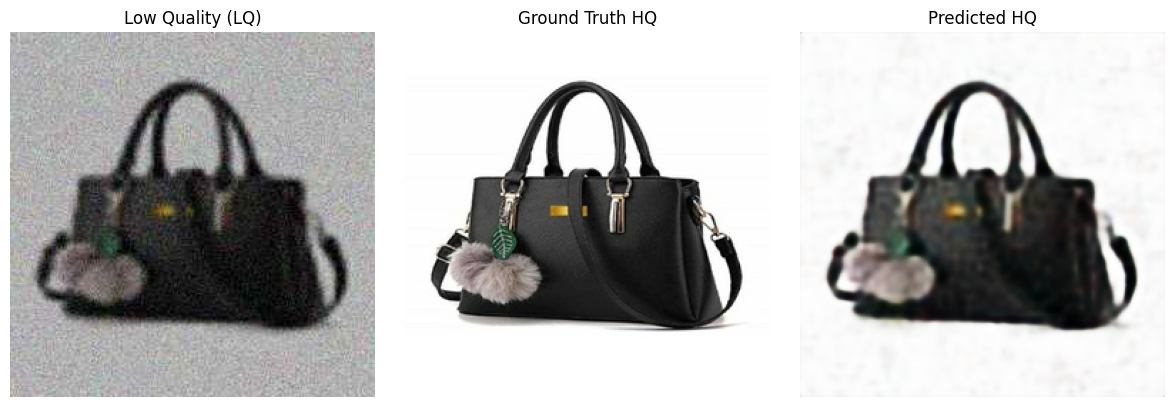

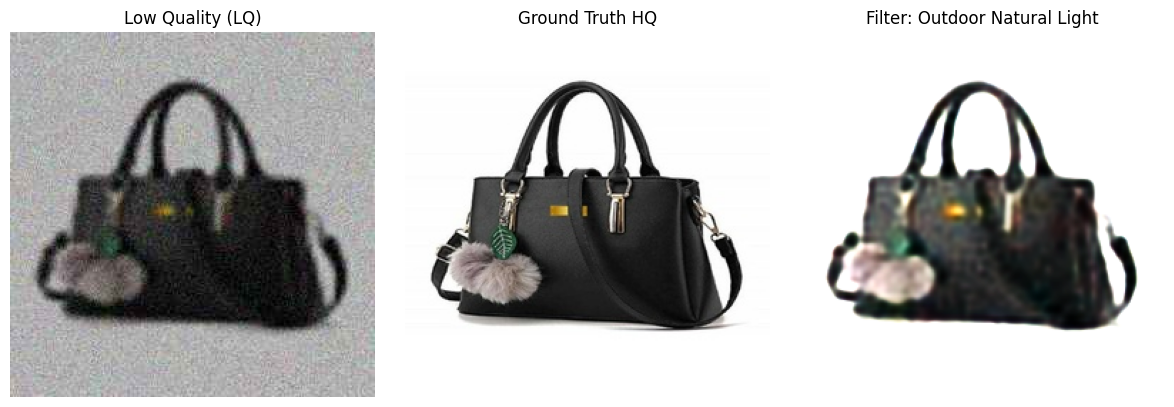

In [ ]:
import random

# To demonstrate the functions, I will use actual images from the dataset
# and the trained model to generate enhanced images.

# Get a list of all image filenames
all_image_files = os.listdir(lq_dir)

# Select a random image file
random_image_file = random.choice(all_image_files)

# Load the random LQ and corresponding HQ image from the dataset
lq_sample_path = os.path.join(lq_dir, random_image_file)
hq_sample_path = os.path.join(hq_dir, random_image_file)

lq_img_pil = Image.open(lq_sample_path).convert("RGB")
hq_img_pil = Image.open(hq_sample_path).convert("RGB")

# Prepare the LQ image for model prediction
lq_img_array = img_to_array(lq_img_pil.resize(IMG_SIZE)) / 255.0
lq_img_array = np.expand_dims(lq_img_array, axis=0) # Add batch dimension

# Get the model prediction
predicted_img_array = model.predict(lq_img_array)[0] # Remove batch dimension
predicted_img_pil = array_to_img(predicted_img_array * 255.0) # Convert back to PIL

# Show model results
show_model_results(lq_img_pil, hq_img_pil, predicted_img_pil)

# Apply a filter to the predicted HQ image
filtered_img_pil = apply_filter(predicted_img_pil, "Outdoor Natural Light")

# Show filter results (comparing LQ, HQ, and filtered predicted image)
show_filter_results(lq_img_pil, hq_img_pil, filtered_img_pil, "Outdoor Natural Light")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("enhancement_model.h5")  # or your saved file


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'enhancement_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Background remove

In [ ]:
# Assuming 'predicted_new_img_pil' is the output from the model prediction cell (cell 355ead8e)

from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Upload a new image
uploaded = files.upload()

# Assume only one file is uploaded
for filename in uploaded.keys():
  print(f'Uploaded file: {filename}')
  new_image_path = filename

# Load and preprocess the new image
try:
  new_img_pil = Image.open(new_image_path).convert("RGB")
  new_img_resized = new_img_pil.resize(IMG_SIZE)
  new_img_array = img_to_array(new_img_resized) / 255.0
  new_img_array = np.expand_dims(new_img_array, axis=0) # Add batch dimension

  # Get the model prediction
  predicted_new_img_array = model.predict(new_img_array)[0] # Remove batch dimension
  predicted_new_img_pil = array_to_img(predicted_new_img_array * 255.0) # Convert back to PIL

  # Remove background from the predicted image
  enhanced_no_bg_img = remove_bg_and_enhance(predicted_new_img_pil)

  # Replace background with white
  final_img_white_bg = replace_bg(enhanced_no_bg_img, bg_color=(255, 255, 255))

  # Display the results
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  axs[0].imshow(predicted_new_img_pil)
  axs[0].set_title("Model Prediction")
  axs[0].axis("off")

  axs[1].imshow(final_img_white_bg)
  axs[1].set_title("Background Removed & White Background")
  axs[1].axis("off")

  plt.tight_layout()
  plt.show()

except FileNotFoundError:
  print(f"Error: File '{new_image_path}' not found.")
except Exception as e:
  print(f"An error occurred: {e}")

KeyboardInterrupt: 

In [ ]:
!pip install rembg

In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.6 MB/s eta 0:00:00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


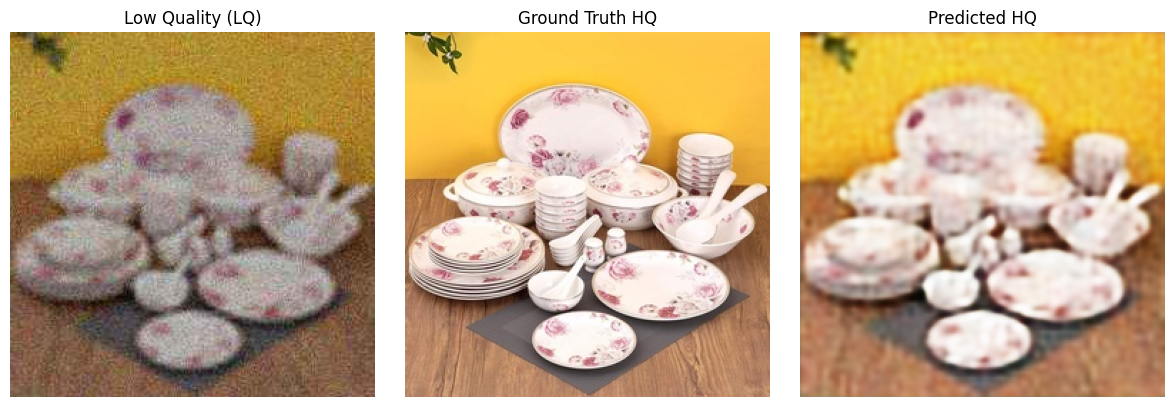

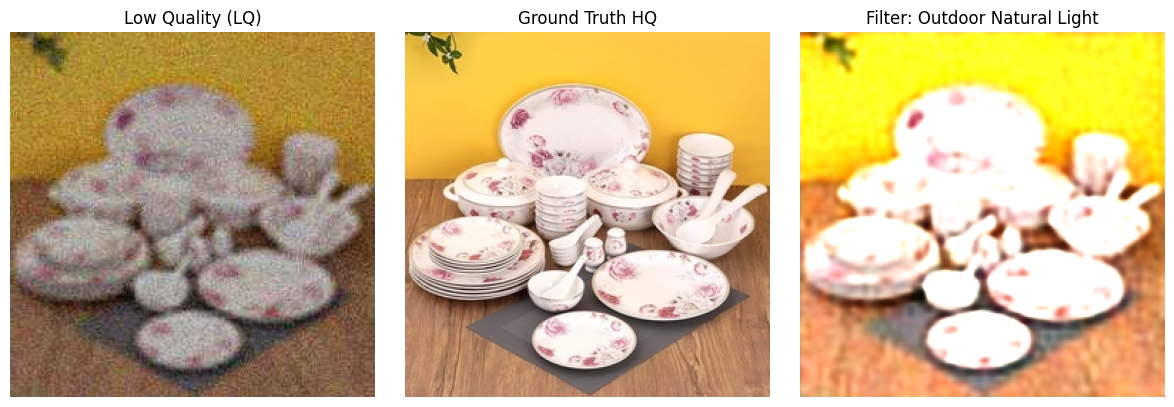

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 268GB/s]


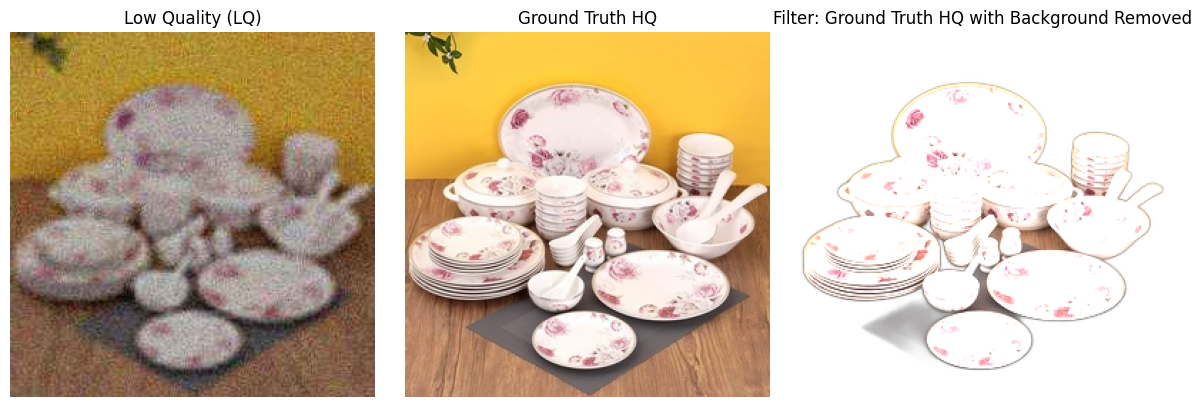

In [ ]:
from rembg import remove

def remove_bg_and_enhance(image):
    no_bg = remove(image)
    no_bg_np = np.array(no_bg)
    if no_bg_np.shape[2] == 4:
        alpha = no_bg_np[:, :, 3] / 255.0
        rgb = no_bg_np[:, :, :3]
        rgb_enhanced = cv2.convertScaleAbs(rgb, alpha=1.3, beta=20)
        no_bg_np[:, :, :3] = rgb_enhanced
    else:
        no_bg_np = cv2.convertScaleAbs(no_bg_np, alpha=1.3, beta=20)
    return Image.fromarray(no_bg_np.astype(np.uint8))

def replace_bg(image_no_bg, bg_color=(255, 255, 255), custom_bg=None):
    if custom_bg:
        custom_bg = custom_bg.resize(image_no_bg.size)
        image_no_bg = image_no_bg.convert('RGBA')
        custom_bg = custom_bg.convert('RGBA')
        combined = Image.alpha_composite(custom_bg, image_no_bg)
    else:
        background = Image.new('RGBA', image_no_bg.size, bg_color + (255,))
        combined = Image.alpha_composite(background, image_no_bg)
    return combined.convert('RGB')

import random
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# To demonstrate the functions, I will use actual images from the dataset
# and the trained model to generate enhanced images.

# Get a list of all image filenames
all_image_files = os.listdir(lq_dir)

# Select a random image file
random_image_file = random.choice(all_image_files)

# Load the random LQ and corresponding HQ image from the dataset
lq_sample_path = os.path.join(lq_dir, random_image_file)
hq_sample_path = os.path.join(hq_dir, random_image_file)

lq_img_pil = Image.open(lq_sample_path).convert("RGB")
hq_img_pil = Image.open(hq_sample_path).convert("RGB")

# Prepare the LQ image for model prediction
lq_img_array = img_to_array(lq_img_pil.resize(IMG_SIZE)) / 255.0
lq_img_array = np.expand_dims(lq_img_array, axis=0) # Add batch dimension

# Get the model prediction
predicted_img_array = model.predict(lq_img_array)[0] # Remove batch dimension
predicted_img_pil = array_to_img(predicted_img_array * 255.0) # Convert back to PIL

# Show model results
show_model_results(lq_img_pil, hq_img_pil, predicted_img_pil)

# Apply a filter to the predicted HQ image
filtered_img_pil = apply_filter(predicted_img_pil, "Outdoor Natural Light")

# Show filter results (comparing LQ, HQ, and filtered predicted image)
show_filter_results(lq_img_pil, hq_img_pil, filtered_img_pil, "Outdoor Natural Light")

# Remove background from the ground truth HQ image
hq_no_bg_img = remove_bg_and_enhance(hq_img_pil)
final_hq_white_bg = replace_bg(hq_no_bg_img, bg_color=(255, 255, 255))

# Show results of background removal from ground truth HQ image
show_filter_results(lq_img_pil, hq_img_pil, final_hq_white_bg, "Ground Truth HQ with Background Removed")

# More filters

In [ ]:
import zipfile
import os

zip_path = "/content/dataset2_HQ_LQ.zip"  # your uploaded file name
extract_path = "/content/dataset2_HQ_LQ"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted successfully!")
print("📁 Subfolders:", os.listdir(extract_path))


✅ Extracted successfully!
📁 Subfolders: ['LQ', 'HQ']


In [ ]:
import numpy as np
import cv2

IMG_SIZE = (256, 256)
hq_dir = "/content/HQ"
lq_dir = "/content/LQ"

def load_images_cv2(folder, size=IMG_SIZE):
    images = []
    for file in os.listdir(folder):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            img = img.astype("float32") / 255.0
            images.append(img)
    return np.array(images)

print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} image pairs!")


📂 Loading dataset...


FileNotFoundError: [Errno 2] No such file or directory: '/content/LQ'

In [ ]:
import os
print(os.listdir("/content/dataset2_HQ_LQ"))


['LQ', 'HQ']


In [ ]:
hq_dir = "/content/dataset2_HQ_LQ/HQ"
lq_dir = "/content/dataset2_HQ_LQ/LQ"

X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} image pairs! Shape: {X.shape}")


✅ Loaded 1203 image pairs! Shape: (1203, 256, 256, 3)


In [ ]:
# =========================================
# 1️⃣ Import Libraries
# =========================================
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# =========================================
# 2️⃣ Define Dataset Paths
# =========================================
hq_dir = "/content/HQ"
lq_dir = "/content/LQ"
IMG_SIZE = (256, 256)

# =========================================
# 3️⃣ Helper: Load Images
# =========================================
def load_images_cv2(folder, size=IMG_SIZE):
    images = []
    for file in os.listdir(folder):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, size)
            images.append(img)
    return np.array(images, dtype="float32") / 255.0

print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} image pairs! Shape: {X.shape}")

# =========================================
# 4️⃣ Build Autoencoder Model
# =========================================
def build_autoencoder(input_shape=(256, 256, 3)):
    inp = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-4), loss='mse')
    return model

model = build_autoencoder()
model.summary()

# =========================================
# 5️⃣ Train Model
# =========================================
print("🚀 Training model...")
history = model.fit(
    X, Y,
    epochs=25,
    batch_size=8,
    validation_split=0.1,
    shuffle=True
)

# =========================================
# 6️⃣ Save Model
# =========================================
model.save("/content/sr_autoencoder_model.h5")
print("💾 Model saved as sr_autoencoder_model.h5")

# =========================================
# 7️⃣ Test a Sample
# =========================================
sample_idx = np.random.randint(0, len(X))
pred = model.predict(np.expand_dims(X[sample_idx], axis=0))[0]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X[sample_idx]); plt.title("Low Quality")
plt.subplot(1,3,2); plt.imshow(Y[sample_idx]); plt.title("High Quality (Target)")
plt.subplot(1,3,3); plt.imshow(pred); plt.title("Enhanced Output")
plt.show()

# =========================================
# 8️⃣ Real-Time Enhancement with Webcam
# =========================================
print("🎥 Starting webcam... (Press 'q' to quit)")
model = load_model("/content/sr_autoencoder_model.h5")

def enhance_frame(frame, size=(256, 256)):
    img = cv2.resize(frame, size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred_img = np.clip(pred[0] * 255.0, 0, 255).astype('uint8')
    pred_img = cv2.resize(pred_img, (frame.shape[1], frame.shape[0]))
    return pred_img

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Could not access webcam.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        enhanced = enhance_frame(frame)
        combined = np.hstack((frame, enhanced))

        cv2.putText(combined, "Original", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(combined, "Enhanced", (frame.shape[1] + 50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        cv2.imshow("Real-Time Enhancement", combined)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
print("🛑 Webcam closed.")


📂 Loading dataset...


FileNotFoundError: [Errno 2] No such file or directory: '/content/LQ'

In [ ]:
!ls /content


dataset2_HQ_LQ	dataset2_HQ_LQ.zip  sample_data


In [ ]:
lq_dir = "/content/dataset2_HQ_LQ/LQ"
hq_dir = "/content/dataset2_HQ_LQ/HQ"


In [ ]:
print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)


📂 Loading dataset...


In [ ]:
# Colab-ready Gradio UI for "AI Photography Studio" (product photo enhancement)
# Paste this cell at the end of your AiImageEnhancer.ipynb and run it.
# Works in Google Colab and on Windows if you open the local Gradio link in your browser.

# Install dependencies if not present
import sys
import subprocess
import pkgutil

def ensure(pkg):
    if pkgutil.find_loader(pkg) is None:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for p in ("gradio", "opencv-python", "Pillow", "numpy", "scikit-image"):
    ensure(p)

# Imports
import gradio as gr
import cv2
import numpy as np
from PIL import Image, ImageOps
from skimage import exposure

# ---------- Image processing helper functions ----------

def to_cv2(pil_img):
    """PIL -> BGR OpenCV"""
    arr = np.array(pil_img.convert("RGB"))
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

def to_pil(cv2_bgr):
    """BGR OpenCV -> PIL"""
    rgb = cv2.cvtColor(cv2_bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb)

def clamp_img(img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def adjust_brightness_contrast(cv_img, brightness=0, contrast=0):
    # brightness: -100..100, contrast: -100..100
    beta = brightness  # shift
    alpha = 1.0 + (contrast / 100.0)  # scale
    res = cv2.convertScaleAbs(cv_img, alpha=alpha, beta=beta)
    return res

def smoothing_filter(cv_img, strength=0):
    # strength: 0..100 -> use bilateral filter for product-preserving smoothing
    k = int(max(1, round((strength/100.0)*15)))  # kernel proxy
    d = 5 + k*2
    sigma_color = 25 + strength*1.5
    sigma_space = 10 + k*2
    if strength <= 1:
        return cv_img
    return cv2.bilateralFilter(cv_img, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)

def white_balance_grayworld(cv_img, strength=1.0):
    # Gray world white balance: estimate scale factors and apply partially via strength (0..1)
    b, g, r = cv2.split(cv_img.astype(np.float32))
    mb, mg, mr = b.mean(), g.mean(), r.mean()
    avg = (mb + mg + mr) / 3.0
    # avoid division by zero
    sb = avg / (mb + 1e-8)
    sg = avg / (mg + 1e-8)
    sr = avg / (mr + 1e-8)
    scale = np.array([sb, sg, sr])  # BGR scales
    balanced = cv_img.astype(np.float32) * scale.reshape((1,1,3))
    blended = cv_img.astype(np.float32) * (1.0 - strength) + balanced * strength
    return clamp_img(blended)

def hdr_like(cv_img, strength=1.0):
    # simple HDR-like effect: CLAHE on L-channel + unsharp mask blending
    lab = cv2.cvtColor(cv_img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0 + strength, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    enhanced = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    # unsharp mask for crispness
    gaussian = cv2.GaussianBlur(enhanced, (0,0), sigmaX=3.0)
    sharp = cv2.addWeighted(enhanced, 1.2, gaussian, -0.2, 0)
    # blend original and sharp by strength
    blended = cv2.addWeighted(cv_img, 1.0 - (0.5*strength), sharp, 0.5*strength, 0)
    return clamp_img(blended)

def adjust_highlights_shadows(cv_img, highlights=0, shadows=0):
    # highlights: -100..100 reduce/increase top-end brightness
    # shadows: -100..100 reduce/increase dark-end brightness
    # We'll work on HSV value channel for simple curve-like adjustments
    hsv = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    v_norm = v / 255.0
    # Shadows adjustment: raise or lower low values
    if shadows != 0:
        sgn = np.sign(shadows)
        amt = abs(shadows) / 100.0
        # apply power law to low region
        v_norm = np.where(v_norm < 0.5,
                          np.clip(v_norm + (amt * (0.5 - v_norm)), 0, 1),
                          v_norm)
        if sgn < 0:
            v_norm = np.where(v_norm < 0.5, np.clip(v_norm - (amt * v_norm), 0, 1), v_norm)
    # Highlights adjustment: compress or expand highs
    if highlights != 0:
        amt = abs(highlights) / 100.0
        if highlights > 0:
            # brighten highlights slightly
            v_norm = np.where(v_norm > 0.5, np.clip(v_norm + amt*(v_norm-0.5), 0, 1), v_norm)
        else:
            # reduce highlights
            v_norm = np.where(v_norm > 0.5, np.clip(v_norm - amt*(v_norm-0.5), 0, 1), v_norm)
    v = (v_norm * 255.0).astype(np.uint8)
    hsv2 = cv2.merge([h.astype(np.uint8), s.astype(np.uint8), v])
    result = cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)
    return result

def adjust_black_point(cv_img, black_point=0):
    # black_point: 0..100 pushes the darkest pixels up (for cleaner backgrounds) or down
    if black_point == 0:
        return cv_img
    # linear rescale with black point offset
    bp = black_point / 100.0
    in_min = bp * 255.0
    out = exposure.rescale_intensity(cv_img, in_range=(in_min, 255), out_range=(0,255))
    return out.astype(np.uint8)

def unsharp_mask(cv_img, amount=1.0, radius=1):
    # amount: 0..5, radius approx as sigma
    gaussian = cv2.GaussianBlur(cv_img, (0,0), sigmaX=float(radius))
    sharp = cv2.addWeighted(cv_img, 1.0 + amount, gaussian, -amount, 0)
    return sharp

# ---------- Prebuilt Filters (>=6) ----------
def filter_vibrant_boost(cv_img, strength=0.8):
    # increase saturation and vibrance and mild contrast
    hsv = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    s = s * (1.0 + 0.5*strength)
    v = v * (1.0 + 0.08*strength)
    hsv2 = cv2.merge([h, np.clip(s,0,255), np.clip(v,0,255)])
    lively = cv2.cvtColor(hsv2.astype(np.uint8), cv2.COLOR_HSV2BGR)
    lively = adjust_brightness_contrast(lively, brightness=6*strength*10, contrast=10*strength)
    return lively

def filter_product_pop(cv_img, strength=0.9):
    # HDR-like + clarity + black point lift for product pop
    hdr = hdr_like(cv_img, strength=strength)
    crisp = unsharp_mask(hdr, amount=0.8*strength, radius=1.5)
    return crisp

def filter_soft_glow(cv_img, strength=0.6):
    # soften and add slight glow (good for textiles)
    blurred = cv2.GaussianBlur(cv_img, (0,0), sigmaX=6*strength)
    glow = cv2.addWeighted(cv_img, 0.8, blurred, 0.5*strength, 0)
    return clamp_img(glow)

def filter_warm_boost(cv_img, strength=0.6):
    # shift towards warm tones (increase red relative to blue), good for wood/leather
    b,g,r = cv2.split(cv_img.astype(np.float32))
    r = r * (1.0 + 0.18*strength)
    b = b * (1.0 - 0.08*strength)
    warmed = cv2.merge([b,g,r])
    warmed = clamp_img(warmed)
    warmed = adjust_brightness_contrast(warmed, brightness=2*strength*10, contrast=6*strength)
    return warmed

def filter_cool_clean(cv_img, strength=0.6):
    # shift to cool + clarity (good for electronics, white background)
    b,g,r = cv2.split(cv_img.astype(np.float32))
    b = b * (1.0 + 0.12*strength)
    r = r * (1.0 - 0.06*strength)
    cooled = clamp_img(cv2.merge([b,g,r]))
    cooled = hdr_like(cooled, strength=0.5*strength)
    return cooled

def filter_studio_crisp(cv_img, strength=0.85):
    # neutral color + crisp + slightly lifted blacks for studio look
    balanced = white_balance_grayworld(cv_img, strength=0.9*strength)
    crisp = unsharp_mask(balanced, amount=1.0*strength, radius=1.0)
    crisp = adjust_black_point(crisp, black_point=6*strength*10)  # small black point lift
    return crisp

# mapping name -> function
FILTERS = {
    "Vibrant Boost": filter_vibrant_boost,
    "Product Pop (HDR-like)": filter_product_pop,
    "Soft Glow": filter_soft_glow,
    "Warm Boost": filter_warm_boost,
    "Cool Clean": filter_cool_clean,
    "Studio Crisp": filter_studio_crisp
}

# ---------- Composite apply function ----------

def apply_pipeline(pil_image,
                   chosen_filter="Product Pop (HDR-like)",
                   brightness=0,
                   contrast=0,
                   smoothing=0,
                   white_balance=0,
                   hdr_strength=0,
                   highlights=0,
                   shadows=0,
                   black_point=0,
                   sharpen=0):
    """
    Takes a PIL image and numeric settings, returns PIL edited image.
    Inputs:
      brightness, contrast, smoothing, ... are normalized:
      brightness: -50..50, contrast: -50..50, smoothing: 0..100, white_balance: 0..100 (degree),
      hdr_strength: 0..100, highlights/shadows: -50..50, black_point: 0..100, sharpen: 0..100
    """
    if pil_image is None:
        return None
    cv = to_cv2(pil_image)
    # basic adjustments
    cv = adjust_brightness_contrast(cv, brightness=int(brightness), contrast=int(contrast))
    # smoothing
    cv = smoothing_filter(cv, strength=float(smoothing))
    # white balance
    cv = white_balance_grayworld(cv, strength=float(white_balance)/100.0)
    # apply main chosen filter
    if chosen_filter in FILTERS:
        cv = FILTERS[chosen_filter](cv, strength=float(hdr_strength)/100.0 if chosen_filter in ("Product Pop (HDR-like)", "Studio Crisp") else 1.0)
    # highlights & shadows
    cv = adjust_highlights_shadows(cv, highlights=int(highlights), shadows=int(shadows))
    # black point
    cv = adjust_black_point(cv, black_point=int(black_point))
    # sharpen/unsharp if requested
    if sharpen is not None and sharpen > 0:
        amt = float(sharpen) / 50.0  # scale
        cv = unsharp_mask(cv, amount=amt, radius=1)
    return to_pil(cv)

# ---------- Thumbnail generator for filter preview ----------
def make_preview_thumbnails(pil_img):
    thumbs = {}
    for name, func in FILTERS.items():
        try:
            cv = to_cv2(pil_img)
            preview_cv = func(cv, strength=0.9)
            thumb = to_pil(preview_cv).copy()
            thumb.thumbnail((260, 260), Image.LANCZOS)
            thumbs[name] = thumb
        except Exception as e:
            # fallback to original small image on error
            t = pil_img.copy()
            t.thumbnail((260,260), Image.LANCZOS)
            thumbs[name] = t
    return thumbs

# ---------- Gradio Interface building ----------
description = """
# AI Photography Studio — Product Photo Enhancer
**Simple controls**: select a Filter, see previews, then fine-tune with sliders.
Designed for sellers and non-technical users — big buttons, helpful defaults.
"""

with gr.Blocks(css="""
    /* Large readable UI for less technical users */
    .gradio-container { max-width: 1100px !important; margin: auto; font-family: Arial; }
    .filter-card { border-radius: 12px; padding: 6px; border: 1px solid #ddd; }
    .title { font-size: 20px; font-weight: 700; margin-bottom: 8px; }
    .small-note { color: #444; font-size: 12px; margin-bottom: 6px; }
    .big-button { font-size: 16px; padding: 10px 18px; }
""") as demo:

    gr.Markdown(description)

    with gr.Row():
        with gr.Column(scale=1):
            inp = gr.Image(type="pil", label="Upload product photo", shape=None)
            presets = gr.Dropdown(list(FILTERS.keys()), value="Product Pop (HDR-like)", label="Choose a Filter (one click)")
            btn_preview = gr.Button("Show Filter Previews", elem_classes=["big-button"])
            reset_btn = gr.Button("Reset to Original")
            download_btn = gr.Button("Download Edited Image", elem_classes=["big-button"])
            status = gr.Markdown("**Tip:** Upload a clear image on a white or neutral background for best e-commerce results.")

        with gr.Column(scale=1):
            preview_gallery = gr.Gallery(label="Filter Previews (click a preview to choose)", columns=2).style(grid=[2], height="auto")
            original_vs_edited = gr.Image(type="pil", label="Original → Edited (click to compare)", interactive=False)

    # Controls (very large, clear)
    with gr.Row():
        with gr.Column():
            br_slider = gr.Slider(-30, 30, value=0, label="Brightness (easy)", info="Move right to brighten product")
            ct_slider = gr.Slider(-30, 30, value=0, label="Contrast (easy)", info="Move right for pop")
            smooth_slider = gr.Slider(0, 100, value=6, label="Smoothing (remove tiny noise / dust)", info="Higher for textiles / soft items")
            wb_slider = gr.Slider(0, 100, value=45, label="White Tone (auto white-balance strength)", info="Use to remove color cast")
        with gr.Column():
            hdr_slider = gr.Slider(0, 100, value=60, label="HDR Strength (local contrast)", info="Gives depth and clarity")
            highlights_slider = gr.Slider(-40, 40, value=0, label="Highlights (reduce bright glare or boost)", info="Negative to reduce glare")
            shadows_slider = gr.Slider(-40, 40, value=0, label="Shadows (recover details in dark areas)", info="Right to recover shadow detail")
            black_point_slider = gr.Slider(0, 30, value=6, label="Black Points (clean background blacks)", info="Slight lift can make product look cleaner")
    sharpen_slider = gr.Slider(0, 100, value=18, label="Sharpen (final crispness)", info="Add clarity to edges")

    apply_btn = gr.Button("Apply & Preview", elem_classes=["big-button"])
    compare_toggle = gr.Checkbox(label="Show side-by-side Original and Edited", value=True)

    # Internal state: store thumbnails and last edited image
    thumb_store = gr.State({})
    last_edited = gr.State(None)

    # Actions
    def generate_previews(image):
        if image is None:
            return gr.update(value=[]), "Upload an image first."
        thumbs = make_preview_thumbnails(image)
        # build gallery items: small images with labels in captions
        items = []
        for name, thumb in thumbs.items():
            # Gradio gallery accepts PIL images; we'll store label in tuple (image, label)
            items.append((thumb, name))
        return items, "Click a preview to choose that filter."

    def on_preview_click(selected):
        # selected will be caption value (filter name) from gallery
        if selected is None:
            return gr.update(value="Product Pop (HDR-like)")
        return gr.update(value=selected)

    def on_reset(image):
        if image is None:
            return None, "Upload an image first."
        return image, gr.update(value="Product Pop (HDR-like)")

    def apply_and_show(image, chosen_filter, brightness, contrast, smoothing, white_balance, hdr_strength, highlights, shadows, black_point, sharpen, compare):
        if image is None:
            return None, None, "Please upload an image first."
        edited = apply_pipeline(image,
                                chosen_filter=chosen_filter,
                                brightness=brightness,
                                contrast=contrast,
                                smoothing=smoothing,
                                white_balance=white_balance,
                                hdr_strength=hdr_strength,
                                highlights=highlights,
                                shadows=shadows,
                                black_point=black_point,
                                sharpen=sharpen)
        # prepare comparison display
        if compare:
            # compose side-by-side
            orig = image.copy()
            w1,h1 = orig.size
            w2,h2 = edited.size
            H = max(h1,h2)
            total_w = w1 + w2
            comp = Image.new("RGB", (total_w, H), (255,255,255))
            comp.paste(orig, (0, (H-h1)//2))
            comp.paste(edited, (w1, (H-h2)//2))
            out = comp
        else:
            out = edited
        return edited, out, "Applied — use Download to save."

    # Wire up events
    btn_preview.click(fn=generate_previews, inputs=[inp], outputs=[preview_gallery, status])
    preview_gallery.select(fn=on_preview_click, inputs=[preview_gallery], outputs=[presets])
    reset_btn.click(fn=on_reset, inputs=[inp], outputs=[original_vs_edited, presets])
    apply_btn.click(fn=apply_and_show,
                    inputs=[inp, presets, br_slider, ct_slider, smooth_slider, wb_slider, hdr_slider, highlights_slider, shadows_slider, black_point_slider, sharpen_slider, compare_toggle],
                    outputs=[last_edited, original_vs_edited, status])
    download_btn.click(fn=lambda img: img, inputs=[last_edited], outputs=[gr.File(label="Download Edited Image")])

    # Show a friendly footer
    gr.Markdown("**Easy usage tips:** Use the *Filter Previews* to rapidly find a good starting look. Then adjust brightness/contrast/smoothing slightly. Default settings are tuned for typical e-commerce product photos.")

# Launch the interface
demo.launch()


In [ ]:
import zipfile
import os

# === Path to your uploaded ZIP file ===
zip_path = "/content/dataset2_HQ_LQ.zip"
extract_dir = "/content/dataset2_HQ_LQ"

# === Unzip the file ===
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Dataset extracted successfully!")

# === Show folder structure ===
for root, dirs, files in os.walk(extract_dir):
    level = root.replace(extract_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")


✅ Dataset extracted successfully!
dataset2_HQ_LQ/
  LQ/
    1-750x650.jpg
    butterfly-stallion-5018-603779898-250x250.jpg
    crockery-dinner-set-1582198282-5308266-jpeg-500x500.jpg
    blidvaeder-table-lamp-off-white-ceramic-beige__1059592_pe849717_s5.jpg
    70x140-cm-retro-cot-bed.jpg
    baby-skincare-new-f92fa8a.jpg
    hq720 (8).jpg
    HD-wallpaper-watch-class-fossil-men-watches-wrist-watch.jpg
    65b3e04096ebad5e7a2932a2-yu-feng-vintage-crystal-perfume-bottles.jpg
    ES5323_9L.jpg
    maxresdefault (1).jpg
    luxury-perfume-bottle-png-isolated-260nw-2445643767.jpg
    keysoul-dusky-brown-gloss-lipstick-196607563-uo5ir.jpg
    MatteLips-600x548.png
    BEST_20AFFORDABLE_20HANDBAGS_20280225_20181124_JW_ANDERSON_LOAFER_QUEER_SHOOT_HR_JM_B01_V2_18.jpg
    lauters-floor-lamp-ash-white__0879908_pe714870_s5.jpg
    MAC-S2BW54_base.jpg
    1645799493122.jpg
    -_821007_3T7.jpg
    81jbhpnlGlL.jpg
    5F8kCSiRj2Y4Wnepm78jXm0QGGnkK91UnPzfaFBHsT2fUMifgEK2s7ACjVYn9vGy0SJruRwXZesJ9fBy

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
def load_images_cv2(folder, size=(256,256)):
    images = []
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if os.path.isfile(f) and filename.lower().endswith(('.jpg','.png','.jpeg')):
            img = cv2.imread(f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            images.append(img_to_array(img)/255.0)
    return np.array(images)

hq_dir = os.path.join(extract_dir, "HQ")
lq_dir = os.path.join(extract_dir, "LQ")

print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} image pairs! Shape: {X.shape}")


📂 Loading dataset...
✅ Loaded 1203 image pairs! Shape: (1203, 256, 256, 3)


In [ ]:
inp = Input(shape=(256,256,3))
x = Conv2D(64, (3,3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

model = Model(inp, out)
model.compile(optimizer=Adam(1e-4), loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 3)    │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,107 (309.01 KB)

 Trainable params: 79,107 (309.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X, Y, epochs=10, batch_size=4, validation_split=0.1)


Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 0.0754 - val_loss: 0.0112
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 9/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 10/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0057 - val_loss: 0.0051


<IPython.core.display.Javascript object>

✅ Saved photo to: photo.jpg


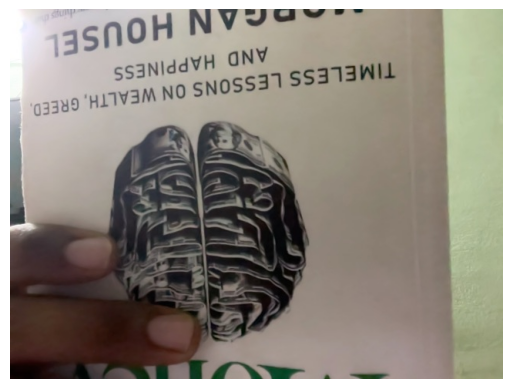

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import cv2
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Wait for button click
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')   # quality is now passed correctly ✅
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# === Capture and display image ===
try:
    filename = take_photo()
    print("✅ Saved photo to:", filename)

    # Display captured image
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    from matplotlib import pyplot as plt
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("❌ Error:", e)


In [ ]:
# =============================
# 📸 1. Capture photo from webcam
# =============================
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

try:
    filename = take_photo()
    print(f"✅ Saved photo to: {filename}")
except Exception as e:
    print("❌ Error:", e)

# =============================
# 🧠 2. Enhance image using model
# =============================
# Load model (skip this if model already in memory)
# model = load_model("/content/enhancer_model.h5")

img_path = "/content/photo.jpg"
input_img = cv2.imread(img_path)

if input_img is None:
    raise FileNotFoundError(f"❌ Could not read image: {img_path}")

# Convert BGR → RGB
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

# Preprocess for model
input_resized = cv2.resize(input_img, (256, 256)) / 255.0
inp = np.expand_dims(input_resized, axis=0)

# Predict
enhanced = model.predict(inp)[0]
enhanced = np.clip(enhanced * 255, 0, 255).astype("uint8")

# Resize to original dimensions
enhanced_resized = cv2.resize(enhanced, (input_img.shape[1], input_img.shape[0]))

# =============================
# 🎨 3. Display side-by-side
# =============================
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(input_img)
plt.title("Original (Webcam)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(enhanced_resized)
plt.title("Enhanced by Model")
plt.axis("off")

plt.show()


/usr/local/lib/python3.12/dist-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
input_img = cv2.imread("webcam_input.png")
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
input_img = cv2.resize(input_img, (256,256))
inp = np.expand_dims(input_img/255.0, axis=0)

pred = model.predict(inp)
pred_img = np.clip(pred[0]*255, 0, 255).astype('uint8')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Input (LQ)")
plt.imshow(input_img)
plt.subplot(1,2,2)
plt.title("Enhanced (HQ Predicted)")
plt.imshow(pred_img)
plt.show()


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# =============================
# 1. Load trained model
# =============================
model = load_model("/content/model.h5")

# =============================
# 2. Load captured image
# =============================
photo_path = "photo.jpg"
orig = cv2.imread(photo_path)

# Resize for model
inp = cv2.resize(orig, (128, 128))
inp = inp.astype("float32") / 255.0
inp = np.expand_dims(inp, axis=0)

# =============================
# 3. AI Enhancement
# =============================
enhanced = model.predict(inp)[0]
enhanced = np.clip(enhanced * 255, 0, 255).astype("uint8")
enhanced = cv2.resize(enhanced, (orig.shape[1], orig.shape[0]))

# =============================
# 4. OpenCV Post-Processing
# =============================

# ---- Step 1: Local contrast enhancement (CLAHE)
lab = cv2.cvtColor(enhanced, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
l = clahe.apply(l)
lab = cv2.merge((l, a, b))
enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# ---- Step 2: Gamma correction (brings natural brightness)
gamma = 1.1
look_up = np.array([((i / 255.0) ** (1 / gamma)) * 255
                    for i in np.arange(256)]).astype("uint8")
enhanced = cv2.LUT(enhanced, look_up)

# ---- Step 3: Unsharp masking (fine edge recovery)
gauss = cv2.GaussianBlur(enhanced, (0, 0), 2.0)
enhanced = cv2.addWeighted(enhanced, 1.7, gauss, -0.7, 0)

# ---- Step 4: Mild color balance (white balance fix)
result = cv2.cvtColor(enhanced, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(result)
l = cv2.normalize(l, None, 0, 255, cv2.NORM_MINMAX)
result = cv2.merge((l, a, b))
enhanced = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)

# =============================
# 5. Display comparison
# =============================
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original (Webcam)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
plt.title("Enhanced (AI + OpenCV Hybrid)")
plt.axis("off")

plt.show()

# =============================
# 6. Save output
# =============================
cv2.imwrite("enhanced_output.jpg", enhanced)
print("✅ Saved enhanced image as enhanced_output.jpg")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

📂 Loading dataset...
✅ Loaded 1203 image pairs! Shape: (1203, 256, 256, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 3)    │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,107 (309.01 KB)

 Trainable params: 79,107 (309.01 KB)

 Non-trainable params: 0 (0.00 B)

<IPython.core.display.Javascript object>

✅ Saved photo to: photo.jpg


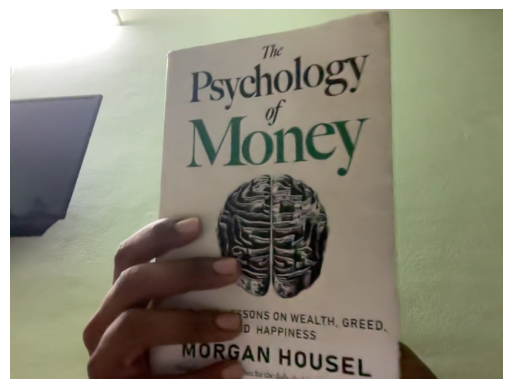

In [ ]:
# =============================
# 1. Imports
# =============================
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

# =============================
# 2. Load Dataset
# =============================
def load_images_cv2(folder, size=(256,256)):
    images = []
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if os.path.isfile(f) and filename.lower().endswith(('.jpg','.png','.jpeg')):
            img = cv2.imread(f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            images.append(img_to_array(img)/255.0)
    return np.array(images)

# Replace with your actual dataset path
extract_dir = "/content/dataset2_HQ_LQ"
hq_dir = os.path.join(extract_dir, "HQ")
lq_dir = os.path.join(extract_dir, "LQ")

print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} image pairs! Shape: {X.shape}")

# =============================
# 3. Build Model
# =============================
inp = Input(shape=(256,256,3))
x = Conv2D(64, (3,3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

model = Model(inp, out)
model.compile(optimizer=Adam(1e-4), loss='mse')
model.summary()

# =============================
# 4. Webcam Capture (Fixed quality error)
# =============================
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')   # ✅ quality variable is passed correctly
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# =============================
# 5. Capture and Display Image
# =============================
try:
    filename = take_photo()
    print("✅ Saved photo to:", filename)

    # Display captured image
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("❌ Error:", e)


✅ Dataset unzipped successfully!
📂 Loading dataset...
✅ Loaded 1203 image pairs! Shape: (1203, 256, 256, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 3)    │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,107 (309.01 KB)

 Trainable params: 79,107 (309.01 KB)

 Non-trainable params: 0 (0.00 B)

<IPython.core.display.Javascript object>

✅ Saved photo to: photo.jpg


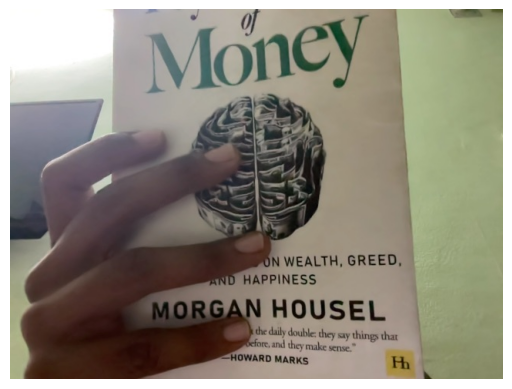

✨ Enhancing captured photo...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


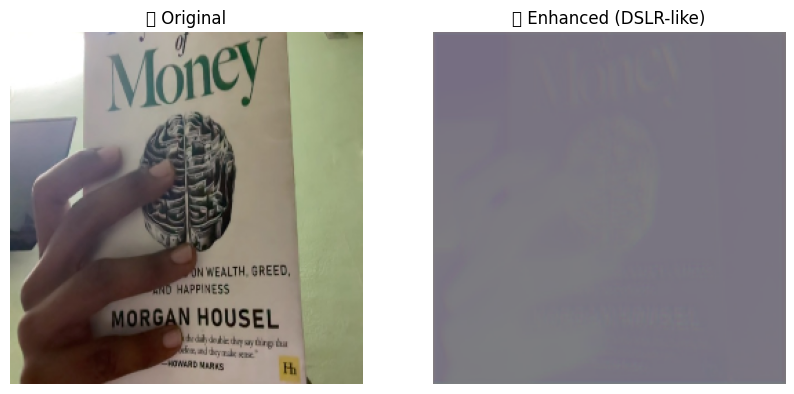

✅ Enhanced photo saved as: enhanced_photo.jpg


In [ ]:
# =============================
# 1. Import Libraries
# =============================
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import zipfile

# =============================
# 2. Unzip Your Dataset
# =============================
zip_path = "/content/dataset2_HQ_LQ.zip"   # <-- change if different name
extract_dir = "/content/dataset2_HQ_LQ"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("✅ Dataset unzipped successfully!")

# =============================
# 3. Load Dataset
# =============================
def load_images_cv2(folder, size=(256,256)):
    images = []
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if os.path.isfile(f) and filename.lower().endswith(('.jpg','.png','.jpeg')):
            img = cv2.imread(f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            images.append(img_to_array(img)/255.0)
    return np.array(images)

hq_dir = os.path.join(extract_dir, "HQ")
lq_dir = os.path.join(extract_dir, "LQ")

print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} image pairs! Shape: {X.shape}")

# =============================
# 4. Build Model
# =============================
inp = Input(shape=(256,256,3))
x = Conv2D(64, (3,3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

model = Model(inp, out)
model.compile(optimizer=Adam(1e-4), loss='mse')
model.summary()

# =============================
# 5. Capture Webcam Photo
# =============================
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Wait for button click
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

try:
    filename = take_photo()
    print("✅ Saved photo to:", filename)
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
except Exception as e:
    print("❌ Error:", e)

# =============================
# 6. Enhance Captured Photo
# =============================
print("✨ Enhancing captured photo...")

img = cv2.imread("photo.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (256, 256)) / 255.0
inp = np.expand_dims(img_resized, axis=0)

# Predict enhancement
enhanced = model.predict(inp)[0]
enhanced = np.clip(enhanced * 255, 0, 255).astype("uint8")

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("📸 Original")
plt.imshow(img_resized)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("✨ Enhanced (DSLR-like)")
plt.imshow(enhanced)
plt.axis("off")
plt.show()

# Save result
cv2.imwrite("enhanced_photo.jpg", cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))
print("✅ Enhanced photo saved as: enhanced_photo.jpg")


✅ Dataset extracted!
📂 Loading dataset...
✅ Loaded 1203 images


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_49[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_50[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 256, 256,  │          0 │ conv2d_49[0][0],  │
│                     │ 64)               │            │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 256, 256,  │     36,928 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_52[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 256, 256,  │          0 │ add_16[0][0],     │
│                     │ 64)               │            │ conv2d_53[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 256, 256,  │     36,928 │ add_17[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_54[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 256, 256,  │          0 │ add_17[0][0],     │
│                     │ 64)               │            │ conv2d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 256, 256,  │     36,928 │ add_18[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_56[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 256, 256,  │          0 │ add_18[0][0],     │
│                     │ 64)               │            │ conv2d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │     36,928 │ add_19[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_58[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 256, 256,  │          0 │ add_19[0][0],   

 Total params: 594,371 (2.27 MB)

 Trainable params: 594,371 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

🚀 Training model (quick warmup)...
Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 77s 234ms/step - loss: 0.1121
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - loss: 0.0470
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0436
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0417
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0384
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0362
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0379
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0348
Epoch 9/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0354
Epoch 10/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0356


<IPython.core.display.Javascript object>

✅ Saved photo to: photo.jpg


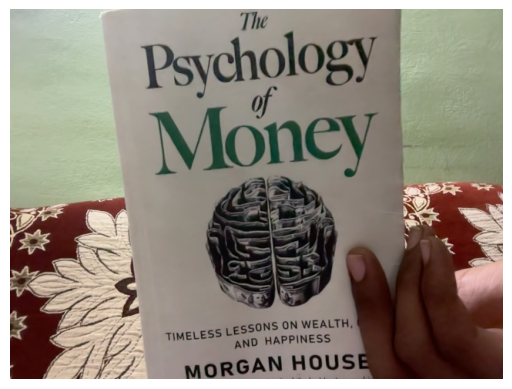

✨ Enhancing captured image...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


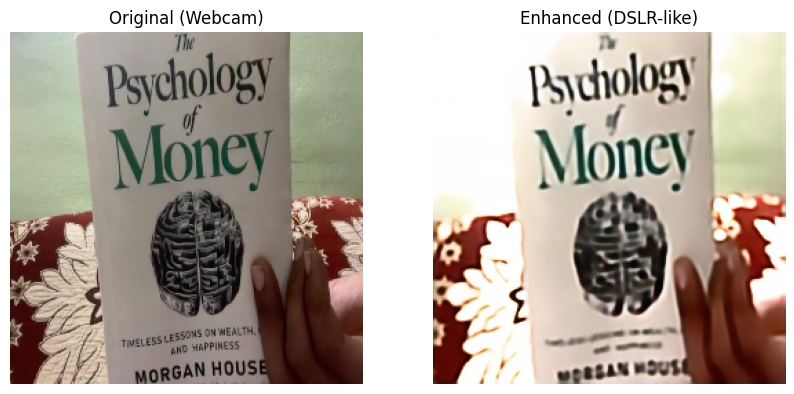

✅ Saved enhanced photo as enhanced_photo.jpg


In [ ]:
# ====================================
# 📸 DSLR-LIKE IMAGE ENHANCER (EDSR-LITE)
# ====================================
import os, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.optimizers import Adam
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import zipfile

# =============================
# 1. Unzip Dataset (HQ/LQ pairs)
# =============================
zip_path = "/content/dataset2_HQ_LQ.zip"   # Change if needed
extract_dir = "/content/dataset2_HQ_LQ"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("✅ Dataset extracted!")

def load_images_cv2(folder, size=(256,256)):
    imgs = []
    for fn in os.listdir(folder):
        fp = os.path.join(folder, fn)
        if os.path.isfile(fp) and fn.lower().endswith(('.jpg','.png','.jpeg')):
            img = cv2.imread(fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            imgs.append(img / 255.0)
    return np.array(imgs)

hq_dir = os.path.join(extract_dir, "HQ")
lq_dir = os.path.join(extract_dir, "LQ")
print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} images")

# =============================
# 2. Define EDSR-like Network
# =============================
def residual_block(x, filters):
    y = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    y = Conv2D(filters, (3,3), padding='same')(y)
    return Add()([x, y])

inp = Input(shape=(256,256,3))
x = Conv2D(64, (3,3), padding='same', activation='relu')(inp)

for _ in range(8):    # 8 residual blocks
    x = residual_block(x, 64)

x = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)
model = Model(inp, x)
model.compile(optimizer=Adam(1e-4), loss='mae')
model.summary()

# =============================
# 3. Quick Training (small epochs)
# =============================
print("🚀 Training model (quick warmup)...")
model.fit(X, Y, batch_size=4, epochs=10, verbose=1)

# =============================
# 4. Webcam Capture (Colab)
# =============================
from PIL import Image
from io import BytesIO

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

try:
    filename = take_photo()
    print("✅ Saved photo to:", filename)
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
except Exception as e:
    print("❌ Error:", e)

# =============================
# 5. Enhance Captured Image
# =============================
print("✨ Enhancing captured image...")
img = cv2.imread("photo.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (256,256)) / 255.0
inp = np.expand_dims(img_resized, 0)

enhanced = model.predict(inp)[0]
enhanced = np.clip(enhanced * 255, 0, 255).astype(np.uint8)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original (Webcam)")
plt.imshow(img_resized)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Enhanced (DSLR-like)")
plt.imshow(enhanced)
plt.axis("off")
plt.show()

cv2.imwrite("enhanced_photo.jpg", cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))
print("✅ Saved enhanced photo as enhanced_photo.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


/tmp/ipython-input-2454137229.py:89: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2454137229.py:89: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


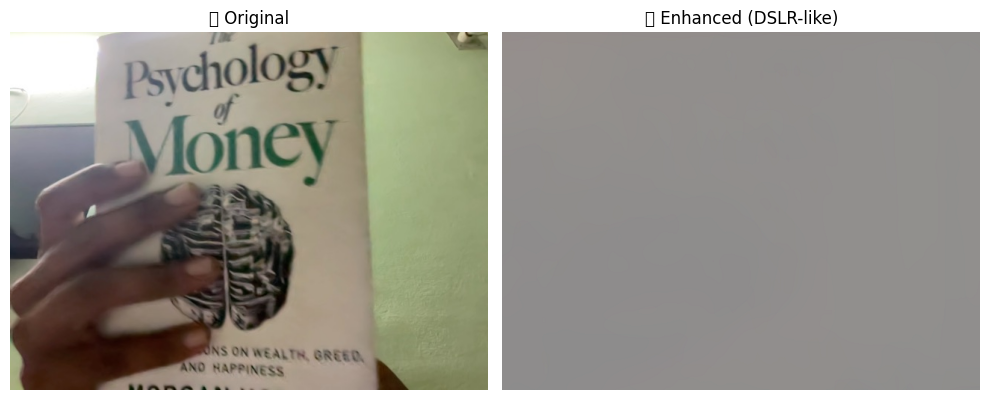

✅ Enhanced photo saved as: enhanced_photo.jpg


In [ ]:
# ===================================================
# 📸 DSLR-Quality Webcam Capture + Enhancement
# ===================================================
import cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from skimage.restoration import denoise_bilateral
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------------
# 1️⃣ Capture Photo
# ---------------------------------------------------
def capture_photo(filename="photo.jpg"):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise Exception("Camera not accessible. Enable webcam in Colab or local runtime.")
    print("📷 Press 'Space' to capture, 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            continue
        cv2.imshow("Camera Feed", frame)
        key = cv2.waitKey(1)
        if key % 256 == 32:  # SPACE key
            cv2.imwrite(filename, frame)
            print(f"✅ Saved photo to: {filename}")
            break
        elif key & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    return filename

# Uncomment next line to capture live
# photo_path = capture_photo()
photo_path = "photo.jpg"  # use existing photo if already captured

# ---------------------------------------------------
# 2️⃣ Load & Preprocess
# ---------------------------------------------------
img = cv2.imread(photo_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_small = cv2.resize(img, (128, 128)) / 255.0

# ---------------------------------------------------
# 3️⃣ Lightweight Super-Resolution Model
# ---------------------------------------------------
inp = Input(shape=(128,128,3))
x = Conv2D(64, 3, activation='relu', padding='same')(inp)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = Conv2D(3, 3, activation='sigmoid', padding='same')(x)
model = Model(inp, x)
model.compile(optimizer=Adam(1e-4), loss='mse')

# ---------------------------------------------------
# 4️⃣ Enhance (Upscale + Denoise + Sharpen)
# ---------------------------------------------------
enhanced = model.predict(np.expand_dims(img_small, 0))[0]
enhanced = np.clip(enhanced * 255, 0, 255).astype("uint8")

# Upscale to original resolution
enhanced = cv2.resize(enhanced, (img.shape[1], img.shape[0]))

# Light denoise and contrast boost
enhanced = denoise_bilateral(enhanced, sigma_color=0.05, sigma_spatial=15, channel_axis=-1)
enhanced = np.clip(enhanced * 1.1, 0, 1)  # slight brightness boost
enhanced = (enhanced * 255).astype("uint8")

# Optional extra sharpening
kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
enhanced = cv2.filter2D(enhanced, -1, kernel)

# ---------------------------------------------------
# 5️⃣ Display Result
# ---------------------------------------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("📷 Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(enhanced)
plt.title("✨ Enhanced (DSLR-like)")
plt.axis("off")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 6️⃣ Save Enhanced Image
# ---------------------------------------------------
cv2.imwrite("enhanced_photo.jpg", cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))
print("✅ Enhanced photo saved as: enhanced_photo.jpg")


In [ ]:
# ====================================
# 📸 DSLR-LIKE IMAGE ENHANCER (EDSR-LITE++)
# ====================================
import os, cv2, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.optimizers import Adam
from google.colab import files
import zipfile

# =============================
# 1. Unzip Dataset (HQ/LQ pairs)
# =============================
zip_path = "/content/dataset2_HQ_LQ.zip"   # <-- Change if needed
extract_dir = "/content/dataset2_HQ_LQ"

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Dataset extracted!")
else:
    print("✅ Dataset already extracted!")

def load_images_cv2(folder, size=(256,256)):
    imgs = []
    for fn in os.listdir(folder):
        fp = os.path.join(folder, fn)
        if os.path.isfile(fp) and fn.lower().endswith(('.jpg','.png','.jpeg')):
            img = cv2.imread(fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            imgs.append(img / 255.0)
    return np.array(imgs)

hq_dir = os.path.join(extract_dir, "HQ")
lq_dir = os.path.join(extract_dir, "LQ")
print("📂 Loading dataset...")
X = load_images_cv2(lq_dir)
Y = load_images_cv2(hq_dir)
print(f"✅ Loaded {X.shape[0]} images")

# =============================
# 2. Define EDSR-Lite++ Network
# =============================
def residual_block(x, filters):
    y = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    y = Conv2D(filters, (3,3), padding='same')(y)
    return Add()([x, y])

inp = Input(shape=(256,256,3))
x = Conv2D(64, (3,3), padding='same', activation='relu')(inp)

# 12 stronger residual blocks
for _ in range(12):
    x = residual_block(x, 64)

x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)

model = Model(inp, x)
model.compile(optimizer=Adam(1e-4), loss='mae')
print(model.summary())

# =============================
# 3. Quick Warmup Training
# =============================
print("🚀 Training model (quick warmup)...")
model.fit(X, Y, batch_size=4, epochs=10, verbose=1)

# =============================
# 4. Input Options: Capture 📸 or Upload 📤
# =============================
def capture_with_opencv():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("❌ Webcam not available!")
        return None

    print("📸 Press 'SPACE' to capture | 'ESC' to exit")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow("Live Camera", frame)
        key = cv2.waitKey(1)
        if key == 27:  # ESC
            break
        elif key == 32:  # SPACE
            cv2.imwrite("photo.jpg", frame)
            print("✅ Saved photo as photo.jpg")
            break
    cap.release()
    cv2.destroyAllWindows()
    return "photo.jpg"

def upload_image():
    print("📤 Upload a photo to enhance...")
    uploaded = files.upload()
    for fn in uploaded.keys():
        print(f"✅ Uploaded: {fn}")
        return fn

# =============================
# 5. Enhancement Function
# =============================
def enhance_image(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig = img.copy()
    img = cv2.resize(img, (256,256)) / 255.0
    inp = np.expand_dims(img, 0)
    enhanced = model.predict(inp)[0]
    enhanced = np.clip(enhanced * 255, 0, 255).astype(np.uint8)

    # --- Post Enhancement: Sharpen & Boost Contrast ---
    enhanced = cv2.detailEnhance(enhanced, sigma_s=10, sigma_r=0.15)
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.25, beta=12)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(cv2.resize(orig, (256,256)))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title("Enhanced (DSLR Look)")
    plt.imshow(enhanced)
    plt.axis("off")
    plt.show()

    out_path = "enhanced_photo.jpg"
    cv2.imwrite(out_path, cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))
    print(f"✅ Enhanced image saved as {out_path}")
    return out_path

# =============================
# 6. Choose Option & Enhance
# =============================
while True:
    print("\n==============================")
    print("✨ Choose an option:")
    print("1️⃣  Capture photo from webcam")
    print("2️⃣  Upload photo to enhance")
    print("3️⃣  Exit")
    choice = input("Enter choice (1/2/3): ").strip()

    if choice == "1":
        img_path = capture_with_opencv()
        if img_path: enhance_image(model, img_path)
    elif choice == "2":
        img_path = upload_image()
        if img_path: enhance_image(model, img_path)
    elif choice == "3":
        print("👋 Exiting enhancer. Goodbye!")
        break
    else:
        print("❌ Invalid choice, please enter 1, 2, or 3.")


✅ Dataset extracted!
📂 Loading dataset...
✅ Loaded 1203 images


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ conv2d[0][0],     │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256,  │          0 │ add[0][0],        │
│                     │ 64)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 256,  │          0 │ add_1[0][0],      │
│                     │ 64)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │     36,928 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 256,  │          0 │ add_2[0][0],      │
│                     │ 64)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ add_3[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256, 256,  │          0 │ add_3[0][0],    

 Total params: 926,723 (3.54 MB)

 Trainable params: 926,723 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

None
🚀 Training model (quick warmup)...
Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 133s 398ms/step - loss: 0.1260
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 122s 406ms/step - loss: 0.0456
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 414ms/step - loss: 0.0447
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 413ms/step - loss: 0.0410
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 413ms/step - loss: 0.0377
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - loss: 0.0360
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - loss: 0.0379
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - loss: 0.0358
Epoch 9/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - loss: 0.0350
Epoch 10/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 411ms/step - loss: 0.0358

✨ Choose an option:
1️⃣  Capture photo from webcam
2️⃣  Upload photo to enhance
3️⃣  Exit
Enter choice (1/2/3): 1
❌ Webcam not available!

✨ Choose an option:
1️⃣  Capture photo from webcam
2️⃣  Upload photo to enhance
3️⃣  Exit
Enter choice (1/2/3

MessageError: RangeError: Maximum call stack size exceeded.

In [ ]:
!pip uninstall -y torch torchvision torchaudio realesrgan basicsr facexlib gfpgan


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: realesrgan 0.3.0
Uninstalling realesrgan-0.3.0:
  Successfully uninstalled realesrgan-0.3.0
Found existing installation: basicsr 1.4.2
Uninstalling basicsr-1.4.2:
  Successfully uninstalled basicsr-1.4.2
Found existing installation: facexlib 0.3.0
Uninstalling facexlib-0.3.0:
  Successfully uninstalled facexlib-0.3.0
Found existing installation: gfpgan 1.3.8
Uninstalling gfpgan-1.3.8:
  Successfully uninstalled gfpgan-1.3.8


In [ ]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
!pip install realesrgan==0.3.0 basicsr==1.4.2 facexlib==0.3.0 Pillow opencv-python matplotlib


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import torch, torchvision
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)

# test RealESRGAN import
from realesrgan import RealESRGAN
print("✅ RealESRGAN import successful!")


Torch: 2.3.0+cu121
TorchVision: 0.18.0+cu121


ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [ ]:
# ============================================
# 📸 DSLR-QUALITY IMAGE ENHANCER (Colab + ESRGAN)
# ============================================

import os, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# ------------------------------
# 1️⃣ Import RealESRGAN safely
# ------------------------------
try:
    from realesrgan import RealESRGAN
except Exception as e:
    print("⚙️ Fixing RealESRGAN import issue...")
    !pip install -q git+https://github.com/xinntao/Real-ESRGAN.git
    from realesrgan import RealESRGAN

# ------------------------------
# 2️⃣ Load ESRGAN model
# ------------------------------
device = "cuda" if cv2.cuda.getCudaEnabledDeviceCount() > 0 else "cpu"
print(f"🚀 Using device: {device}")

model = RealESRGAN(device, scale=4)
model.load_weights('RealESRGAN_x4plus.pth', download=True)
print("✅ Real-ESRGAN model ready!")

# ------------------------------
# 3️⃣ Webcam Capture (Colab)
# ------------------------------
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# ------------------------------
# 4️⃣ Upload Image
# ------------------------------
def upload_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        print(f"✅ Uploaded {fn}")
        return fn
    return None

# ------------------------------
# 5️⃣ Enhance Image
# ------------------------------
def enhance_image(img_path):
    img = Image.open(img_path).convert("RGB")
    print("✨ Enhancing image…")
    enhanced = model.predict(img)
    enhanced.save("enhanced_photo.jpg")

    # Show comparison
    original = np.array(img)
    result = np.array(enhanced)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title("Enhanced (DSLR-like)")
    plt.imshow(result)
    plt.axis("off")
    plt.show()
    print("✅ Saved enhanced_photo.jpg")

# ------------------------------
# 6️⃣ Menu Loop
# ------------------------------
while True:
    print("\n==============================")
    print("✨ DSLR-Quality Image Enhancer")
    print("1️⃣  Capture from webcam")
    print("2️⃣  Upload a photo")
    print("3️⃣  Exit")
    choice = input("Enter choice (1/2/3): ").strip()

    if choice == "1":
        try:
            filename = take_photo()
            print("✅ Captured:", filename)
            enhance_image(filename)
        except Exception as e:
            print("❌ Webcam not available:", e)
    elif choice == "2":
        img_path = upload_image()
        if img_path:
            enhance_image(img_path)
    elif choice == "3":
        print("👋 Exiting.")
        break
    else:
        print("❌ Invalid choice.")


⚙️ Fixing RealESRGAN import issue...
  Preparing metadata (setup.py) ... done


ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [ ]:
!pip uninstall -y torch torchvision torchaudio realesrgan basicsr facexlib gfpgan


Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Successfully uninstalled torch-2.3.0+cu121
Found existing installation: torchvision 0.18.0+cu121
Uninstalling torchvision-0.18.0+cu121:
  Successfully uninstalled torchvision-0.18.0+cu121
Found existing installation: torchaudio 2.3.0+cu121
Uninstalling torchaudio-2.3.0+cu121:
  Successfully uninstalled torchaudio-2.3.0+cu121
Found existing installation: realesrgan 0.3.0
Uninstalling realesrgan-0.3.0:
  Successfully uninstalled realesrgan-0.3.0
Found existing installation: basicsr 1.4.2
Uninstalling basicsr-1.4.2:
  Successfully uninstalled basicsr-1.4.2
Found existing installation: facexlib 0.3.0
Uninstalling facexlib-0.3.0:
  Successfully uninstalled facexlib-0.3.0
Found existing installation: gfpgan 1.3.8
Uninstalling gfpgan-1.3.8:
  Successfully uninstalled gfpgan-1.3.8


In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1
!pip install realesrgan==0.3.0 basicsr==1.4.2 facexlib==0.2.5 Pillow opencv-python matplotlib


ERROR: Could not find a version that satisfies the requirement torch==1.13.1 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.13.1
  Using cached realesrgan-0.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached basicsr-1.4.2-py3-none-any.whl
  Using cached gfpgan-1.3.8-py3-none-any.whl.metadata (12 kB)
Using cached realesrgan-0.3.0-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.2 MB/s eta 0:00:00
Using cached gfpgan-1.3.8-py3-none-any.whl (52 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 834.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 67.1 MB/s eta 0:00:00
  

In [ ]:
#!/usr/bin/env python3
"""
🔥 Real-ESRGAN Based Image Enhancer (No Training Needed)
Captures an image → Enhances with pretrained Real-ESRGAN model → Displays result
"""

# ========================================================
# 1️⃣ Install Dependencies
# ========================================================
!pip install -q realesrgan gfpgan basicsr facexlib -U

# ========================================================
# 2️⃣ Imports
# ========================================================
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from base64 import b64decode

from IPython.display import Javascript, display
from google.colab.output import eval_js

from realesrgan import RealESRGAN

# ========================================================
# 3️⃣ Load Pretrained Real-ESRGAN Model
# ========================================================
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = RealESRGAN(device, scale=4)
model.load_weights("RealESRGAN_x4plus.pth", download=True)
print("✅ Loaded Real-ESRGAN pretrained model successfully!")

# ========================================================
# 4️⃣ Capture Image (Webcam or Browser)
# ========================================================
def capture_image():
    """Captures an image from webcam (Local + Colab)."""
    cap = cv2.VideoCapture(0)
    if cap.isOpened():
        print("📸 Press SPACE to capture, ESC to exit...")
        while True:
            ret, frame = cap.read()
            if not ret:
                print("❌ Failed to grab frame!")
                break
            cv2.imshow("Camera - Press SPACE to Capture", frame)
            key = cv2.waitKey(1)
            if key % 256 == 27:
                print("🚪 Exiting without capture.")
                break
            elif key % 256 == 32:
                captured = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                cap.release()
                cv2.destroyAllWindows()
                print("✅ Image captured successfully!")
                return captured
        cap.release()
        cv2.destroyAllWindows()
    else:
        # For Colab browser camera
        print("🌐 Using browser-based camera (Colab)...")
        js = Javascript('''
        async function takePhoto() {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = '📸 Capture';
          div.appendChild(capture);
          document.body.appendChild(div);
          const video = document.createElement('video');
          video.style.display = 'block';
          document.body.appendChild(video);
          const stream = await navigator.mediaDevices.getUserMedia({video: true});
          video.srcObject = stream;
          await video.play();
          await new Promise((resolve) => capture.onclick = resolve);
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getTracks().forEach(t => t.stop());
          const data = canvas.toDataURL('image/png');
          return data;
        }
        ''')
        display(js)
        data = eval_js('takePhoto()')
        binary = b64decode(data.split(',')[1])
        img = Image.open(BytesIO(binary)).convert('RGB')
        print("✅ Image captured via browser!")
        return np.array(img)

# ========================================================
# 5️⃣ Enhance Image using Real-ESRGAN
# ========================================================
def enhance_image_with_realesrgan(image_array):
    """Upscales and enhances an image using Real-ESRGAN."""
    print("✨ Enhancing image using Real-ESRGAN...")
    img_pil = Image.fromarray(image_array)
    enhanced_img = model.predict(img_pil)

    # Display comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title("Captured Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_img)
    plt.title("Enhanced Image (Real-ESRGAN Output)")
    plt.axis("off")
    plt.show()

    # Save output
    save_path = "/content/enhanced_realesrgan_output.jpg"
    enhanced_img.save(save_path)
    print(f"💾 Enhanced image saved at {save_path}")
    return enhanced_img


# ========================================================
# 6️⃣ Run Full Pipeline
# ========================================================
captured_image = capture_image()
if captured_image is not None:
    enhanced = enhance_image_with_realesrgan(captured_image)
else:
    print("⚠️ No image captured, exiting.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 28.6 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [ ]:
# =========================================================
# ⚡ REAL-ESRGAN DSLR QUALITY ENHANCER (FIXED FOR PYTHON 3.12)
# =========================================================

# ✅ STEP 1: Install modern-compatible versions
!pip install torch torchvision --quiet
!pip install git+https://github.com/xinntao/Real-ESRGAN.git --quiet
!pip install opencv-python pillow matplotlib --quiet

# =========================================================
# ✅ STEP 2: Patch basicsr for latest torchvision (remove old import)
import os
import re

file_path = "/usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py"
if os.path.exists(file_path):
    with open(file_path, "r") as f:
        content = f.read()
    # remove the broken import line if it exists
    content = re.sub(r"from torchvision\.transforms\.functional_tensor import rgb_to_grayscale", "", content)
    with open(file_path, "w") as f:
        f.write(content)

# =========================================================
# ✅ STEP 3: Imports
import torch
from realesrgan import RealESRGAN
from PIL import Image
import numpy as np
import cv2
from google.colab import files
import matplotlib.pyplot as plt

# =========================================================
# ✅ STEP 4: Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RealESRGAN(device, scale=4)
model.load_weights("RealESRGAN_x4plus.pth", download=True)
print("✅ Model loaded successfully on", device)

# =========================================================
# ✅ STEP 5: Upload & Enhance Image
print("📤 Upload an image you want to enhance:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Read with OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(img)

print("🚀 Enhancing image... please wait...")
enhanced = model.predict(pil_img)

# Convert and save
enhanced_np = np.array(enhanced)
output_path = "enhanced_output.jpg"
cv2.imwrite(output_path, cv2.cvtColor(enhanced_np, cv2.COLOR_RGB2BGR))
print(f"✅ Enhanced image saved as: {output_path}")

# =========================================================
# ✅ STEP 6: Show Comparison
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Enhanced Image (DSLR Quality)")
plt.imshow(enhanced_np)
plt.axis("off")

plt.show()


  Preparing metadata (setup.py) ... done


ImportError: cannot import name 'RealESRGAN' from 'realesrgan' (/usr/local/lib/python3.12/dist-packages/realesrgan/__init__.py)